<span style="color:deeppink; font-size:35px;"><b>Fig. 1</b></span>

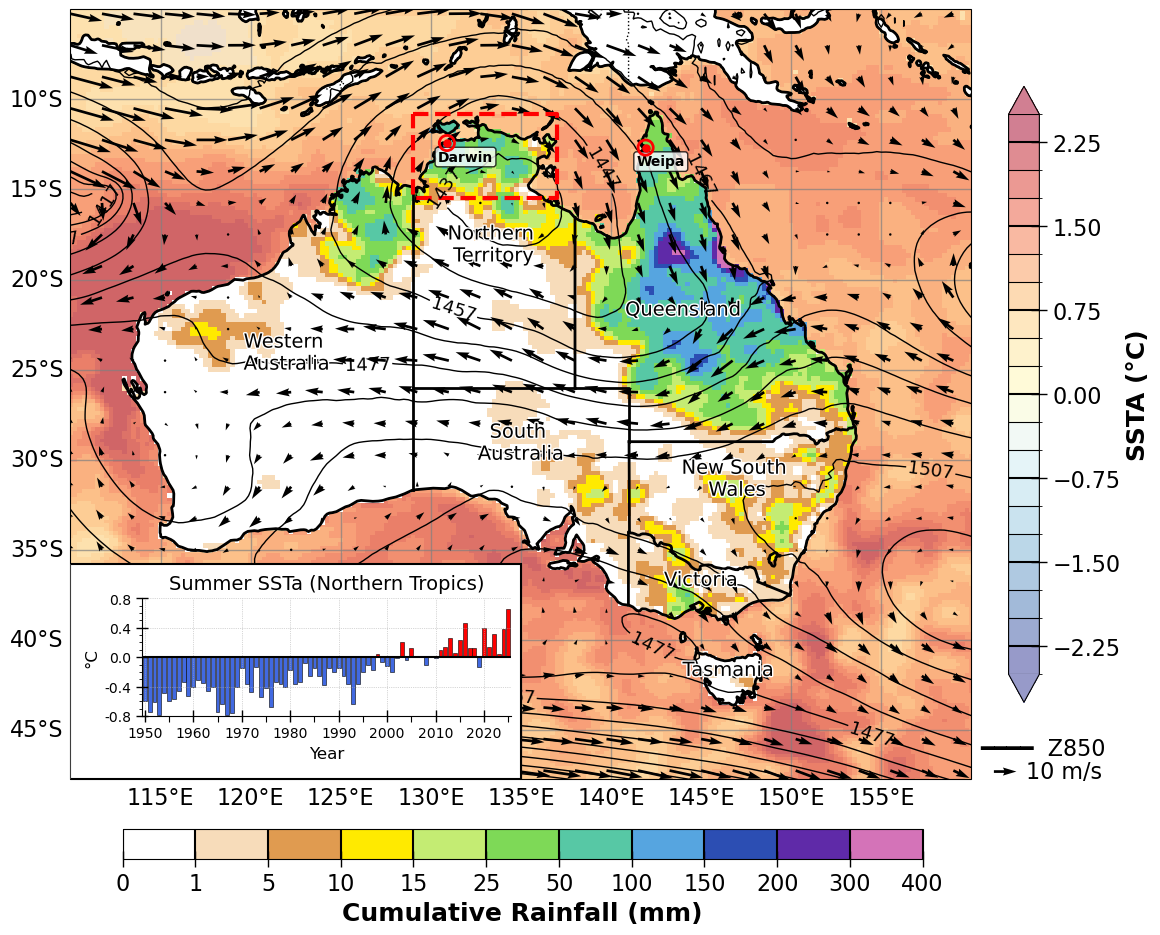

In [2]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib import colors
from datetime import datetime
import geopandas as gpd
import glob
import matplotlib.patheffects as path_effects
import pandas as pd
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.patches import Rectangle
from docx import Document
import matplotlib.ticker as ticker

# File paths
rainfall_file = "/g/data/dx2/txc599/forRaj/precip/precip_total_r005_2025.nc"
uwind_file = "/g/data/dx2/rn0550/Green_Date/ERA5/ERA5_U_850hPa_2024_2025/u_daily_2025_jan_mar.nc"
vwind_file = "/g/data/dx2/rn0550/Green_Date/ERA5/ERA5_V_850hPa_2024_2025/2025/v850_era5_daily_20250203-20250203.nc"
sst_file_daily = "/g/data/dx2/rn0550/Green_Date/ACCESS-S2_Ocean_Reanalysis/SST/sst_anomaly_15Dec_2024_to_6Feb_2025_with19912020clim_1991_2021_ERSSTv5.nc"
hgt_file = "/g/data/dx2/rn0550/Green_Date/ERA5/Geopotential_height_850hPa_daily_4_6_Feb2025.nc"
shapefile_path = "/g/data/dx2/txc599/NAR_onset/papers/Qld_floods_Feb2019/qld-2019-flood-wind-chill-s2s/ne_50m_admin_1_states_provinces_lines.shp"
gdf = gpd.read_file(shapefile_path)
mask_ds = xr.open_dataset("/g/data/dx2/access-s2/calibration/reference/v1/aus_05_land_mask.nc") 
land_mask = mask_ds['land']

lat_extent = slice(0, -50)
lon_extent = slice(110, 160)

start_date1 = "2024-12-15"
start_date = "2025-02-04"  
end_date = "2025-02-06"

start_dt1 = datetime.strptime(start_date1, "%Y-%m-%d")
start_dt = datetime.strptime(start_date, "%Y-%m-%d")
end_dt = datetime.strptime(end_date, "%Y-%m-%d")

formatted_date = f"{start_dt.day}–{end_dt.day}"
formatted_date1 = f"{start_dt1.day}–{end_dt.day}"
###########################################################################################################################################

# Loading rainfall and sst data 
with xr.open_dataset(rainfall_file) as ds_rain:
    cumulative_rainfall = ds_rain["precip"].sel(time=slice("2025-02-03", "2025-02-06")).sum(dim="time")

cumulative_rainfall = cumulative_rainfall.where(land_mask)

with xr.open_dataset(sst_file_daily) as ds_sst_day:
    sst_anomaly = ds_sst_day["sst"].squeeze()  

######################################################################################################################
# Loading uwind data (850 hPa)
u_2025_files = []

for month in ["02"]:  # Feb 2025
    pattern = f"/g/data/dx2/rn0550/Green_Date/ERA5/ERA5_U850/2025/u850_era5_daily_2025{month}*.nc"
    u_2025_files.extend(glob.glob(pattern))

u_2025 = xr.open_mfdataset(u_2025_files, combine='by_coords').sel(
    time=slice(start_date, end_date),
    latitude=lat_extent,
    longitude=lon_extent
)

u_wind_avg = u_2025.mean(dim="time")

######################################################################################################################
# Loading vwind data (850 hPa)
v_2025_files = []

for month in ["02"]:  # Feb 2025
    pattern = f"/g/data/dx2/rn0550/Green_Date/ERA5/ERA5_V_850hPa_2024_2025/2025/v850_era5_daily_2025{month}*.nc"
    v_2025_files.extend(glob.glob(pattern))

v_2025 = xr.open_mfdataset(v_2025_files, combine='by_coords').sel(
    time=slice(start_date, end_date),
    latitude=lat_extent,
    longitude=lon_extent
)

v_wind_avg = v_2025.mean(dim="time")

###########################################################################################################################################
# Loading 850 hPa geopotential height
with xr.open_dataset(hgt_file) as ds_hgt:
    hgt_avg = ds_hgt["z"].sel(valid_time=slice(f"{start_date}", f"{end_date}")).mean(dim="valid_time")

###########################################################################################################################################
# Plotting the combined map
fig, ax = plt.subplots(figsize=(16, 10), subplot_kw={'projection': ccrs.PlateCarree()})
ax.set_extent([110, 160, -45, -5])  
           
# State borders
for geom in gdf.geometry:
    ax.plot(*geom.xy, color='k', linewidth=2, transform=ccrs.PlateCarree(), zorder=4)

state_labels = {
    "Queensland": (144.0, -22.0),
    "New South \nWales": (147.0, -32.0),
    "Victoria": (145.0, -37.0),
    "South \nAustralia": (135.0, -30.0),
    "Western \nAustralia": (122.0, -25.0),
    "Tasmania": (146.5, -42.0),
    "Northern \nTerritory": (133.5, -19.0),
}

for state, (lon, lat) in state_labels.items():
    text1 = ax.text(lon, lat, state, fontsize=14, ha='center', transform=ccrs.PlateCarree(), zorder=5)
    text1.set_path_effects([path_effects.Stroke(linewidth=2, foreground='white'), path_effects.Normal()])

###########################################################################################################################################
# Plotting SSTa
sst_levels = np.linspace(-2.5, 2.5, 21)  
sst_cmap = plt.cm.RdYlBu_r  
sst_norm = colors.BoundaryNorm(sst_levels, sst_cmap.N)
sst_plot = ax.pcolormesh(sst_anomaly.nav_lon, sst_anomaly.nav_lat, sst_anomaly, cmap=sst_cmap, norm=sst_norm, shading='auto', alpha=0.5, transform=ccrs.PlateCarree())
ax.add_feature(cfeature.LAND, facecolor='white', edgecolor='black', zorder=2)
cbar = plt.colorbar(sst_plot, ax=ax, orientation="vertical", shrink=0.8, pad=0.03, label="SSTA (°C)", extend="both")
cbar.ax.set_ylabel("SSTA (°C)", fontsize=18, fontweight='bold')  
cbar.ax.yaxis.set_tick_params(width=1, color='black') 
cbar.ax.grid(color='k', linewidth=1.5, linestyle='-')
cbar.ax.tick_params(axis='y', labelsize=16, length=12, width=1, direction='inout')  
cbar.ax.grid(color='k', linewidth=0.8, linestyle='-', which='minor')  

###########################################################################################################################################
# Plotting rainfall
rain_levels = [0, 1, 5, 10, 15, 25, 50, 100, 150, 200, 300, 400] 
rain_colors = ["white", "#f7dcba", "#e09b50", "#ffea00", "#c4ec73", "#7ed957", 
               "#57c8a5", "#56a5e0", "#2c4eb3", "#5f2aa8", "#be24c7", "#d473b8"]  
rain_cmap = colors.ListedColormap(rain_colors)
rain_norm = colors.BoundaryNorm(rain_levels, rain_cmap.N)
im = cumulative_rainfall.plot(ax=ax, cmap=rain_cmap, norm=rain_norm, levels=rain_levels,
                              add_colorbar=False, zorder=3)  
cax = fig.add_axes([0.23, 0.03, 0.5, 0.03])  
cbar = fig.colorbar(im, cax=cax, orientation="horizontal", extend="neither", spacing="uniform")
cbar.set_ticks(rain_levels)
cbar.ax.set_xticklabels([f"{lvl:.0f}" for lvl in rain_levels], rotation=90)  
cbar.ax.xaxis.set_tick_params(width=1, color='black')  
cbar.ax.grid(color='k', linewidth=1.5, linestyle='-')
cbar.ax.tick_params(axis='x', labelsize=16, length=12, width=1, direction='inout', labelrotation=360) 
cbar.set_label("Cumulative Rainfall (mm)", fontsize=18, fontweight='bold')

###########################################################################################################################################
# Plotting wind vectors
step = 7 
q = ax.quiver(
    u_wind_avg.longitude[::step], 
    u_wind_avg.latitude[::step], 
    u_wind_avg['u'][::step, ::step], 
    v_wind_avg['v'][::step, ::step], 
    transform=ccrs.PlateCarree(), 
    scale=400, 
    color="black", 
    width=0.003, zorder=4)

qk = ax.quiverkey(q, 1.05, 0.01, 10, "10 m/s", labelpos="E", coordinates="axes")
qk.text.set_fontsize(16)

###########################################################################################################################################
# Plotting 850 hPa geopotential height contours
g = 9.80665  
hgt_avg = hgt_avg / g  # converting from m²/s² to m

hgt_levels = np.arange(hgt_avg.min(), hgt_avg.max(), 10) 
hgt_contour = ax.contour(hgt_avg.longitude, hgt_avg.latitude, hgt_avg, levels=hgt_levels, 
                         colors="k", linewidths=1, transform=ccrs.PlateCarree(), zorder=4)

plt.clabel(hgt_contour, inline=True, fontsize=13, fmt="%1.0f")
ax.text(1.01, 0.04, "━━━━  Z850", transform=ax.transAxes, fontsize=16, verticalalignment='center', horizontalalignment='left')
ax.add_feature(cfeature.COASTLINE, linewidth=2, zorder=4)
ax.add_feature(cfeature.BORDERS, linestyle=":", zorder=4)
gl = ax.gridlines(draw_labels=True, 
                  xlocs=np.arange(110, 160, 5),  
                  ylocs=np.arange(-45, -5, 5),  
                  linewidth=1, color='gray', alpha=0.7)  

gl.right_labels = False
gl.top_labels = False
gl.left_labels = True
gl.bottom_labels = True

gl.xlabel_style = {'size': 16} 
gl.ylabel_style = {'size': 16}  

# Marking Darwin and Weipa's locations
darwin_lat = -12.4239
darwin_lon = 130.8925

weipa_lat = -12.6778
weipa_lon = 141.9208

ax.scatter(darwin_lon, darwin_lat, s=120, edgecolor='red', facecolor='none',
           linewidth=2, transform=ccrs.PlateCarree(), zorder=7)

ax.scatter(darwin_lon, darwin_lat, s=26, color='red',
           transform=ccrs.PlateCarree(), zorder=7)

text = ax.text(darwin_lon - 0.5, darwin_lat - 1, "Darwin",
                color='black', fontweight='bold', fontsize=10,
                transform=ccrs.PlateCarree(),
                bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.2', alpha=0.8), zorder=4)


ax.scatter(weipa_lon, weipa_lat, s=120, edgecolor='red', facecolor='none',
           linewidth=2, transform=ccrs.PlateCarree(), zorder=7)

ax.scatter(weipa_lon, weipa_lat, s=26, color='red',
           transform=ccrs.PlateCarree(), zorder=7)

text2 = ax.text(weipa_lon - 0.5, weipa_lat - 1, "Weipa",
                color='black', fontweight='bold', fontsize=10,
                transform=ccrs.PlateCarree(),
                bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.2', alpha=0.8), zorder=4)

############################################################################################################################################
# Top end box
top_end_bbox = [
    (129, -10.8), (137, -10.8),  
    (137, -15.5), (129, -15.5),  
    (129, -10.8)  
]

top_end_lons, top_end_lats = zip(*top_end_bbox)
ax.plot(top_end_lons, top_end_lats, transform=ccrs.PlateCarree(), 
        color='red', linestyle='--', linewidth=3, label="Top End Region", zorder=4)

###################################################################################################
###################################################################################################
# Summer SST anomalies (Northern Tropics) - inset box
inset_box = [0, 0, 0.5, 0.28] 

rect = Rectangle((inset_box[0], inset_box[1]), inset_box[2], inset_box[3],
                 transform=ax.transAxes, facecolor='white', edgecolor='black',
                 linewidth=1.5, zorder=6)

ax.add_patch(rect)

sst_path = "/g/data/dx2/rn0550/Green_Date/Late_Monsoon_Onset_Paper/SST_average_Northern_Tropics_Summer.docx"

doc = Document(sst_path)
data = []

for para in doc.paragraphs:
    line = para.text.strip()
    if not line:
        continue
    try:
        period, anomaly = line.split()
        year = int(period[-6:-2])  
        anomaly = float(anomaly)
        data.append((year, anomaly))
    except ValueError:
        continue  

sst_df = pd.DataFrame(data, columns=["Year", "SST_Anomaly"])

ax_inset = inset_axes(ax, width="100%", height="35%", loc='upper right',
                      bbox_to_anchor=(0.087, -0.195, 0.41, 0.44), 
                      bbox_transform=ax.transAxes)

bar_width = 0.8 

for i, year in enumerate(sst_df['Year']):
    color = 'royalblue' if sst_df['SST_Anomaly'][i] < 0 else 'red'
    ax_inset.bar(year, sst_df['SST_Anomaly'][i], color=color, width=bar_width, align='center', edgecolor='k', linewidth=0.4)
    
ax_inset.set_title("Summer SSTa (Northern Tropics)", fontsize=14)
ax_inset.tick_params(labelsize=10, length=8, width=1, direction='inout')
ax_inset.tick_params(axis='x', labelsize=10, length=8, width=1, direction='inout', labelrotation=360)
ax_inset.axhline(0, color='k', linestyle='-', linewidth=1.5)
ax_inset.set_xlabel("Year", fontsize=12)
ax_inset.set_ylabel("°C", fontsize=12)
tick_positions = np.arange(1950, 2026, 10)
ax_inset.set_xticks(tick_positions)
ax_inset.set_xticklabels([str(year) for year in tick_positions])
ax_inset.set_xlim(1950 - 0.6, 2025 + 0.6)
ax_inset.minorticks_on()
ax_inset.xaxis.set_minor_locator(ticker.AutoMinorLocator(2)) 
ax_inset.tick_params(axis='x', which='minor', length=4, width=0.8, direction='out')
ax_inset.set_yticks(np.arange(-0.8, 0.81, 0.4))  
ax_inset.set_yticklabels([str(round(i, 2)) for i in np.arange(-0.8, 0.81, 0.4)])  
ax_inset.set_ylim(-0.8, 0.81)
ax_inset.grid(True, linestyle=':', linewidth=0.5)
ax_inset.spines['top'].set_visible(False)
ax_inset.spines['right'].set_visible(False)
ax.coastlines()
ax.add_feature(cfeature.BORDERS, linestyle=':', zorder=2)
ax.add_feature(cfeature.LAND, facecolor='white', edgecolor='black', zorder=2)

plt.show()

#fig.savefig(f"g/data/dx2/rn0550/Green_Date/Late_Monsoon_Onset_Paper/Pre-monsoon-onset-conditions_current_year_(2024-2025)_cumul_rain_ssta_4–6_Feb2025_with_SSTA_from_15–6_ERSST.png", dpi=1000, bbox_inches='tight')



<span style="color:deeppink; font-size:35px;"><b>Fig. 3</b></span>

## Darwin D96

/jobfs/142929535.gadi-pbs/ipykernel_781860/1715606586.py:12: UserWarning: Parsing dates in %Y-%m-%d format when dayfirst=True was specified. Pass `dayfirst=False` or specify a format to silence this warning.
  df = pd.read_csv(file_path, parse_dates=['Date'], dayfirst=True)


D96 monsoon onset date for 2024-2025: 2025-02-07 00:00:00


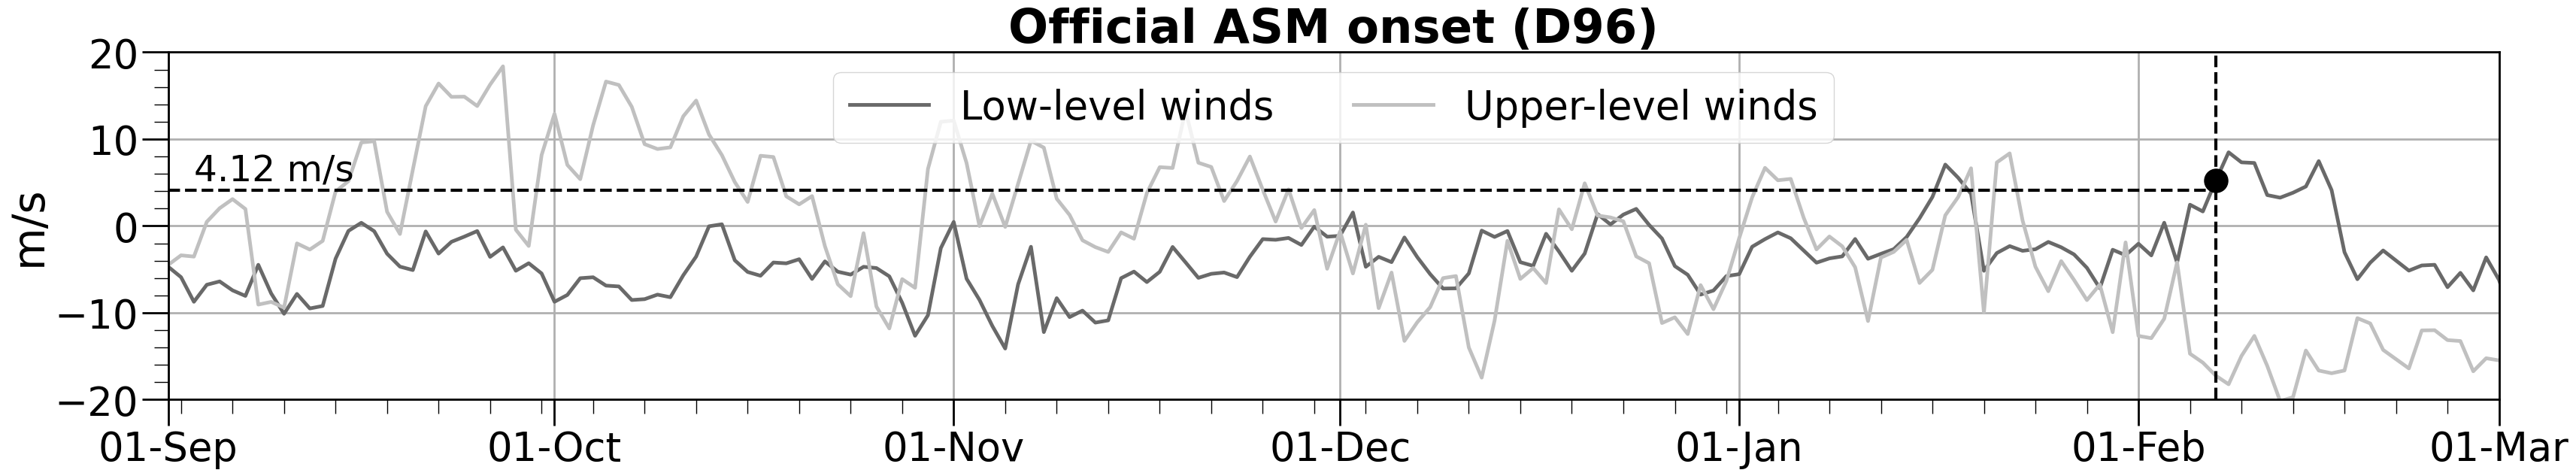

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.dates as mdates

year = 2024
threshold = 4.12

# Loading the weighted uwind data
file_path = "/g/data/dx2/rn0550/Green_Date/Late_Monsoon_Onset_Paper/Radiosonde_Darwin_NEW/NEW_using_Lisonbee_Ribbie_weights_weighted_U_wind_1950_2025.csv"
df = pd.read_csv(file_path, parse_dates=['Date'], dayfirst=True)
df['Hour'] = pd.to_numeric(df['Hour'], errors='coerce')
df = df[df['Hour'] == 0]
start_date, end_date = f"{year}-09-01", f"{year+1}-04-30"
df_period = df[(df['Date'] >= start_date) & (df['Date'] <= end_date)]

def find_monsoon_onset(df):
    onset_date = None

    for i in range(1, len(df)):  
        if (
            df['U_weighted_mean_low'].iloc[i] > 4.12 and  
            df['U_weighted_mean_low'].iloc[i-1] > 4.12 and
            df['U_weighted_mean_upper'].iloc[i] < 0 and  
            df['U_weighted_mean_upper'].iloc[i-1] < 0
        ):
            onset_date = df['Date'].iloc[i-1]
            break  

    return onset_date, df

onset_24_25, df_24_25 = find_monsoon_onset(df_period)

print(f"D96 monsoon onset date for {year}-{year+1}: {onset_24_25}")

################################################################################################################
# Plotting
fig, axs = plt.subplots(figsize=(40, 6), sharex=True)

axs.plot(df_24_25['Date'], df_24_25['U_weighted_mean_low'], label="Low-level winds", color="dimgrey", linewidth=3.5)
axs.plot(df_24_25['Date'], df_24_25['U_weighted_mean_upper'], label="Upper-level winds", color="silver", linewidth=3.5)
axs.set_ylabel("m/s", fontsize=42)
axs.set_title("Official ASM onset (D96)", fontsize=45, fontweight='bold')
axs.legend(fontsize=38, ncols = 2, loc = 'upper center')
axs.grid()
axs.set_xlim(pd.to_datetime("2024-09-01"), pd.to_datetime("2025-03-01"))
axs.tick_params(axis='y', size=38)
axs.tick_params(axis='both', labelsize=38)
axs.set_ylim(-20, 20)
tick_dates = pd.date_range(start="2024-09-01", end="2025-03-01", freq='MS')  
axs.set_xticks(tick_dates)
axs.xaxis.set_major_formatter(mdates.DateFormatter('%d-%b'))
plt.setp(axs.xaxis.get_majorticklabels(), rotation=360, ha="center")

if onset_24_25:
    axs.axvline(onset_24_25, color='black', linestyle='--', linewidth=3)
    #axs.text(onset_24_25 - pd.Timedelta(days=9), 15, onset_24_25.strftime('%d-%b-%Y'), verticalalignment='bottom', horizontalalignment='center', fontsize=12, fontweight='bold')
    onset_y = df_24_25.loc[df_24_25['Date'] == onset_24_25, 'U_weighted_mean_low'].values
    axs.scatter(onset_24_25, onset_y, color='k', edgecolors="black", marker='o', s=500, zorder=3)
    
plt.tick_params(axis='both', labelsize=38) 
plt.minorticks_on()
plt.tick_params(axis='both', which='major', length=25, width=2)  
plt.tick_params(axis='both', which='minor', length=14, width=1) 
axs.xaxis.set_minor_locator(ticker.MultipleLocator(4)) 

for spine in axs.spines.values():
    spine.set_linewidth(2)  

axs.grid(True, linewidth=2)
axs.text(df_24_25['Date'].min() + pd.Timedelta(days=2), threshold + 0.2, f"{threshold} m/s", 
        color="black", fontsize=35, verticalalignment="bottom", horizontalalignment="left") 

if onset_24_25 is not None:
    axs.hlines(y=threshold, xmin=df_24_25['Date'].min(), xmax=onset_24_25, 
               color='k', linestyle='--', linewidth=3)
else:
    axs.axhline(threshold, color='black', linestyle='--', linewidth=3)

plt.show()

#fig.savefig("/g/data/dx2/rn0550/Green_Date/Late_Monsoon_Onset_Paper/FIGURES/new_figs_station_data/1_Drosdowsky_1996_2024-2025_recent.png", dpi=600, bbox_inches='tight')



## Darwin H86

/jobfs/142929535.gadi-pbs/ipykernel_781860/1754526080.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['Two_Day_Period'] = pd.cut(df_filtered['Date'], bins=bins, right=False)
/jobfs/142929535.gadi-pbs/ipykernel_781860/1754526080.py:21: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_2day = df_filtered.groupby('Two_Day_Period', as_index=False)['U'].mean()


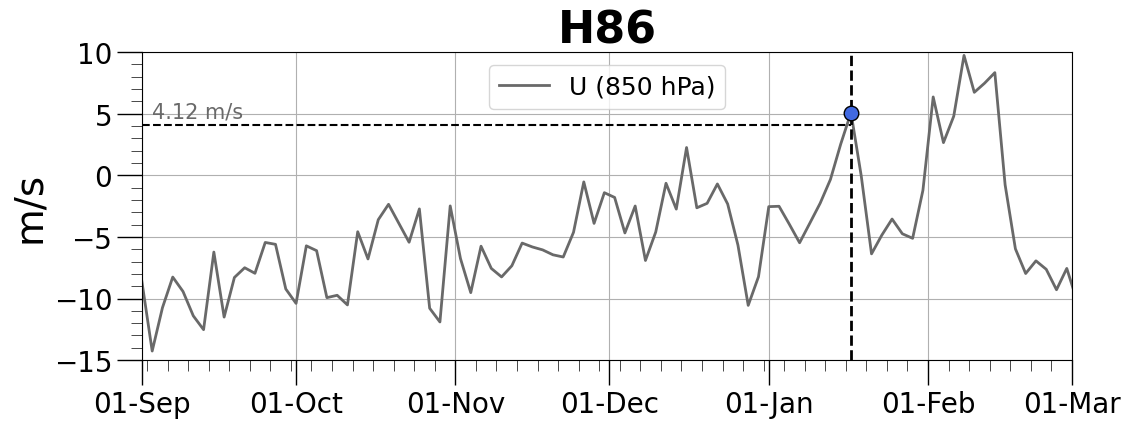

H86 monsoon onset date for 2024-2025: 2025-01-17 00:00:00


In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import UnivariateSpline
import matplotlib.ticker as ticker

threshold = 4.12

# Loading the 850hPa uwind data
df = pd.read_csv("/g/data/dx2/rn0550/Green_Date/Late_Monsoon_Onset_Paper/DARWIN_NEW/Darwin_Press_850hPa_mean_over_hours_NEW_march2025.csv")

df['Date'] = pd.to_datetime(df['Date'], format='mixed', dayfirst=True)
mask = (df['Date'] >= "2024-09-01") & (df['Date'] <= "2025-04-30")
df_filtered = df[mask]

bins = pd.date_range(start=df_filtered['Date'].min(), 
                     end=df_filtered['Date'].max(), 
                     freq='2D')

df_filtered['Two_Day_Period'] = pd.cut(df_filtered['Date'], bins=bins, right=False)
df_2day = df_filtered.groupby('Two_Day_Period', as_index=False)['U'].mean()
df_2day['Two_Day_Period'] = df_2day['Two_Day_Period'].apply(lambda x: x.left)

x_2day = np.arange(len(df_2day))
y_2day = df_2day['U'].values

spline = UnivariateSpline(x_2day, y_2day, s=0)
y_smooth = spline(x_2day)

monsoon_onset_index = np.where(y_smooth >= threshold)[0]
if monsoon_onset_index.size > 0:
    monsoon_onset_date = df_2day.iloc[monsoon_onset_index[0]]['Two_Day_Period']
else:
    monsoon_onset_date = None  
    
#######################################################################################################################
# Plotting
fig, ax = plt.subplots(figsize=(12, 4))

plt.plot(df_2day['Two_Day_Period'], y_smooth, label='U (850 hPa)', color='dimgrey', linewidth=2)

if pd.notna(monsoon_onset_date):
    plt.axvline(monsoon_onset_date, color='k', linestyle='--', linewidth=2)
    plt.scatter(monsoon_onset_date, y_smooth[monsoon_onset_index[0]], color='royalblue', edgecolors="black", marker='o', s=110, zorder=3)  
    #plt.text(monsoon_onset_date + pd.Timedelta(days=12), 5, 
             #monsoon_onset_date.strftime('%d-%b-%Y'), 
             #color='k', fontsize=12, fontweight='bold',  verticalalignment='bottom', horizontalalignment='right')


ax.text(df_2day['Two_Day_Period'].min() + pd.Timedelta(days=2), threshold + 0.2, f"{threshold} m/s", 
        color="dimgrey", fontsize=15, verticalalignment="bottom", horizontalalignment="left")  

if monsoon_onset_date is not None:
    plt.hlines(y=threshold, xmin=df_2day['Two_Day_Period'].min(), xmax=monsoon_onset_date, 
               color='k', linestyle='--', linewidth=1.5)
else:
    plt.axhline(threshold, color='k', linestyle='--', linewidth=1.5) 


plt.ylabel("m/s", fontsize=28)
plt.title("H86", fontsize=32, fontweight='bold')
plt.xticks(rotation=45)
plt.legend(fontsize=18, loc='upper center')
plt.tick_params(axis='both', labelsize=20) 
plt.grid(True)

xticks = pd.date_range(start="2024-09-01", end="2025-03-01", freq='1MS')
plt.xticks(xticks, [date.strftime('%d-%b') for date in xticks], rotation=360, fontsize=20)
plt.minorticks_on()
plt.tick_params(axis='both', which='major', length=18, width=1)  
plt.tick_params(axis='both', which='minor', length=8, width=0.5) 
ax.xaxis.set_minor_locator(ticker.MultipleLocator(4)) 
ax.set_xlim(xticks[0], xticks[-1])
ax.set_ylim(-15, 10)
plt.show()

#fig.savefig("/g/data/dx2/rn0550/Green_Date/Late_Monsoon_Onset_Paper/FIGURES/new_figs_station_data/2_Holland_1986_2024-2025.png", dpi=600, bbox_inches='tight')

print(f"H86 monsoon onset date for {year}-{year+1}: {monsoon_onset_date}")




## Darwin HL90

/jobfs/142929535.gadi-pbs/ipykernel_781860/2849364867.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_wind_year['U_smooth'] = np.convolve(df_wind_year['U'], weights, mode='same')


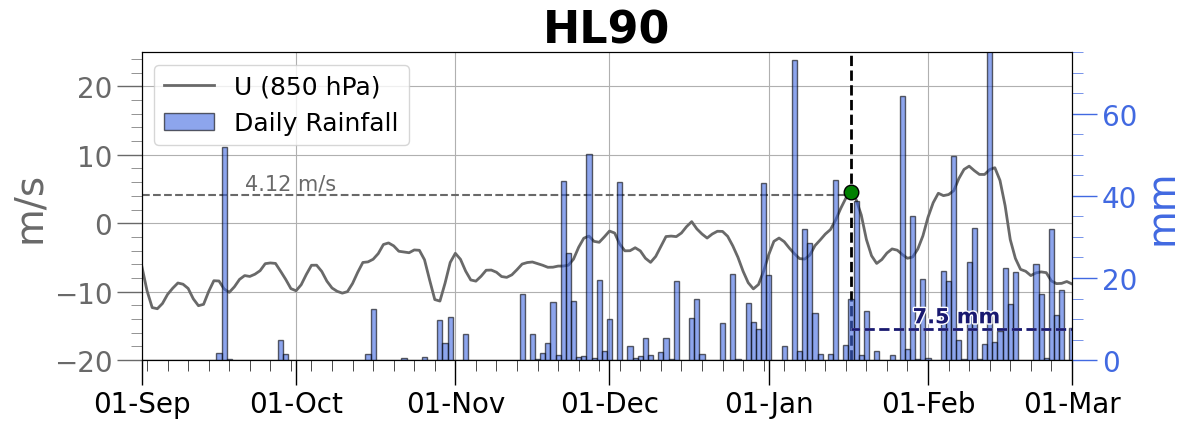

HL90 monsoon onset date for 2024-2025: 2025-01-17 00:00:00


In [6]:
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.ticker as ticker
import matplotlib.patheffects as path_effects

year = 2024
threshold = 4.12

# Loading the 850hPa uwind data
df_wind = pd.read_csv("/g/data/dx2/rn0550/Green_Date/Late_Monsoon_Onset_Paper/DARWIN_NEW/Darwin_Press_850hPa_mean_over_hours_NEW_march2025.csv")

df_wind['Date'] = pd.to_datetime(df_wind['Date'], format='mixed', dayfirst=True)
df_wind['Monsoon_Year'] = df_wind['Date'].apply(lambda x: x.year if x.month >= 9 else x.year - 1)
df_wind = df_wind[(df_wind['Date'].dt.month >= 9) | (df_wind['Date'].dt.month <= 4)]
year = 2024
df_wind_year = df_wind[df_wind['Monsoon_Year'] == year]

# 1-2-3-2-1 weighted moving average filter
weights = np.array([1, 2, 3, 2, 1])
weights = weights / weights.sum()  
df_wind_year['U_smooth'] = np.convolve(df_wind_year['U'], weights, mode='same')

########################################################################################################################
# Loading rainfall data
excel_file_path = "/g/data/dx2/rn0550/Green_Date/Late_Monsoon_Onset_Paper/DARWIN_NEW/Darwin_all_data_1941_2025.xls"
df_rain = pd.read_excel(excel_file_path, sheet_name='NEW', engine='xlrd')  
df_rain.columns = df_rain.columns.str.strip()
date_col = "Day Month Year in DD/MM/YYYY format"
rain_col = "Precipitation in the 24 hours before 9am (local time) in mm"
df_rain["Date"] = pd.to_datetime(df_rain[date_col], dayfirst=True, errors="coerce")
df_rain[rain_col] = pd.to_numeric(df_rain[rain_col], errors="coerce")
df_rain.rename(columns={rain_col: "Rainfall (mm/day)"}, inplace=True)
df_combined = pd.merge(df_wind_year[["Date", "U_smooth"]], df_rain, on="Date", how="inner")
df_combined.rename(columns={"U_smooth": "Wind_Speed (U)"}, inplace=True)

onset_condition = (df_combined["Wind_Speed (U)"] > threshold) & (df_combined["Rainfall (mm/day)"] > 7.5)
onset_date = df_combined.loc[onset_condition, "Date"]

########################################################################################################################
# Plotting
fig, ax = plt.subplots(figsize=(12, 4))

ax.plot(df_wind_year['Date'], df_wind_year['U_smooth'], label="U (850 hPa)", color="dimgrey", linewidth=2)
ax.set_ylabel("m/s", color="dimgrey", fontsize=28)
ax.tick_params(axis='y', labelcolor="dimgrey", labelsize=20)
ax.grid()
ax.text(df_wind_year['Date'].min() + pd.Timedelta(days=20), threshold + 0.2, f"{threshold} m/s", 
        color="dimgrey", fontsize=15, verticalalignment="bottom", horizontalalignment="left") 

ax.set_xlim(df_wind_year['Date'].min(), df_wind_year['Date'].max())
ax.set_ylim(-20, 25)

rain_col = "Rainfall (mm/day)"

ax2 = ax.twinx()
if df_rain is not None:
    ax2.bar(df_rain["Date"], df_rain[rain_col], width=1, color='royalblue', edgecolor='black', alpha=0.6, label='Daily Rainfall', zorder=1)

ax2.set_ylabel("mm", color="royalblue", fontsize=28)
ax2.tick_params(axis='y', labelcolor="royalblue", labelsize=20)

ax2.text(
    df_wind_year['Date'].min() + pd.Timedelta(days=150), 
    7.5 + 0.5, 
    "7.5 mm", 
    color="#191970", 
    fontsize=15, fontweight = 'bold',
    verticalalignment="bottom", 
    horizontalalignment="left",
    path_effects=[path_effects.withStroke(linewidth=2, foreground='white')]
)

ax2.set_ylim(0, 75)
ax2.tick_params(axis='both', labelsize=15)

ax.tick_params(axis='y', labelsize=20, color="dimgrey") 
ax.tick_params(axis='y', which='minor', length=8, width=0.5, color="dimgrey") 
ax.set_title("HL90", fontsize=32, fontweight="bold")
xticks = pd.date_range(start="2024-09-01", end="2025-03-01", freq='1MS')
ax.set_xticks(xticks, [date.strftime('%d-%b') for date in xticks], rotation=360, fontsize=20)
ax.minorticks_on()
ax.tick_params(axis='both', which='major', length=18, width=1)  
ax.tick_params(axis='both', which='minor', length=8, width=0.5) 
ax.xaxis.set_minor_locator(ticker.MultipleLocator(4)) 
ax.set_xlim(xticks[0], xticks[-1])

ax2.minorticks_on()
ax2.tick_params(axis='both', which='major', length=18, width=1, color="royalblue") 
ax2.tick_params(axis='both', which='minor', length=8, width=0.5, color="royalblue") 
ax2.xaxis.set_minor_locator(ticker.MultipleLocator(4)) 
ax2.set_xlim(xticks[0], xticks[-1])
ax2.tick_params(axis='y', labelsize=20)

lines1, labels1 = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax.legend(lines1 + lines2, labels1 + labels2, loc="upper left", fontsize=18)

if not onset_date.empty:
    onset_date = onset_date.iloc[0]
    ax.axvline(onset_date, color='black', linestyle='--', label="Monsoon Onset", linewidth=2)
    onset_wind_speed = df_wind_year.loc[df_wind_year['Date'] == onset_date, 'U_smooth'].values
    ax.scatter(onset_date, onset_wind_speed[0], color='g', edgecolors="black", marker='o', s=110, zorder=3) 
    #ax.text(onset_date + pd.Timedelta(days=8), 20, f"{onset_date.date().strftime('%d-%b-%Y')}", 
            #verticalalignment='bottom', horizontalalignment='right', fontsize=12, color='black', fontweight='bold')


if onset_date is not None:
    ax.hlines(y=threshold, xmin=df_wind_year['Date'].min(), xmax=onset_date, 
               color='dimgrey', linestyle='--', linewidth=1.5)
    ax2.hlines(y=7.5, xmin=df_wind_year['Date'].max(), xmax=onset_date, 
               color='#191970', linestyle='--', linewidth=2, path_effects=[path_effects.withStroke(linewidth=2, foreground='white')])
    
else:
    ax.axhline(threshold, color='dimgrey', linestyle='--', linewidth=1.5)  
    ax2.axhline(7.5, color='blue', linestyle='--', linewidth=1.5) 

plt.show()

#fig.savefig(f"/g/data/dx2/rn0550/Green_Date/Late_Monsoon_Onset_Paper/FIGURES/new_figs_station_data/3_Hendon_Liebmann_1990a_1990b_2024-2025_at_Darwin_U{threshold}mps_rainbars.png", dpi=600, bbox_inches='tight')


print(f"HL90 monsoon onset date for {year}-{year+1}: {onset_date}")



## Darwin HY04

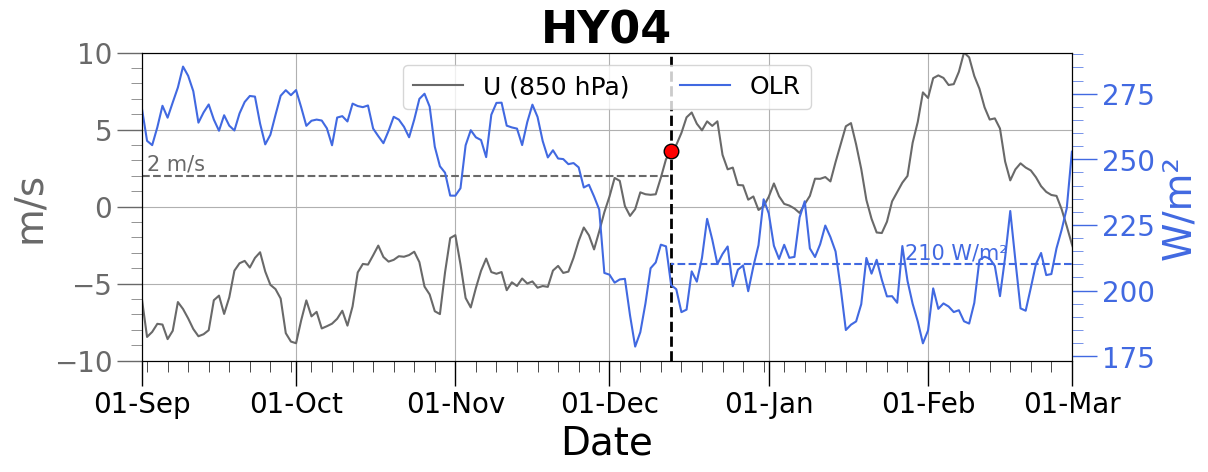

HY04 monsoon onset date for 2024-2025: 2024-12-13 00:00:00


In [1]:
import pandas as pd
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

year = 2024
start_date, end_date = f"{year}-09-01", f"{year+1}-04-30"

# Loading the 850hPa uwind and olr (area-averaged)
file_path1 = "/g/data/dx2/rn0550/Green_Date/ERA5/ERA5_U_850hPa_2024_2025/ERA5_U_850hPa_Sep_Mar_2024_2025_daily_data_areal_averaged.nc"
file_path2 = "/g/data/dx2/rn0550/Green_Date/ERA5/ERA5_OLR_2024_2025/daily_mean_olr_areal_averaged.nc"

ds_uwnd850 = xr.open_mfdataset(file_path1)
ds_olr = xr.open_mfdataset(file_path2)

uwnd_ds_850 = ds_uwnd850.sel(time=slice(start_date, end_date))
olr_ds = ds_olr.sel(valid_time=slice(start_date, end_date))

uwnd_series = uwnd_ds_850["u"]
olr_series = olr_ds["ttr"]

uwnd_series = uwnd_series.rename({'time': 'time'})  
olr_series = olr_series.rename({'valid_time': 'time'})  

################################################################################################################
# Applying the conditions
uwnd_mask = uwnd_series > 2  
olr_mask = olr_series < 210  

uwnd_sustained = uwnd_mask.rolling(time=10, min_periods=10).sum() == 10  # wind condition should sustain for 10 consecutive days
olr_sustained = olr_mask.rolling(time=10, min_periods=10).sum() >= 3  # olr condition should sustain for at least 3 days within the 10-day period

combined_sustained = uwnd_sustained & olr_sustained
combined_sustained_computed = combined_sustained.compute()

if combined_sustained_computed.any():
    last_day_of_sustained_period = combined_sustained_computed.idxmax()  
    first_date = last_day_of_sustained_period - pd.Timedelta(days=9) + pd.Timedelta(days=1)
    last_sustained_date = last_day_of_sustained_period
else:
    first_date = None
    last_sustained_date = None


first_date_dt = pd.to_datetime(first_date) if isinstance(first_date, str) else first_date

################################################################################################################
fig, axs = plt.subplots(figsize=(12, 4), sharex=True)

axs.plot(uwnd_series.time.values, uwnd_series.values, label="U (850 hPa)", color="dimgrey")
axs.set_ylabel("m/s", color="dimgrey", fontsize=28)
axs.set_xlabel("Date", fontsize=28)
axs.tick_params(axis='y', labelcolor="dimgrey", labelsize=20)
axs.tick_params(axis='x', labelsize=20)
axs.text(uwnd_series.time.values.min() + pd.Timedelta(days=1), 2 + 0.1, "2 m/s", 
            color="dimgrey", fontsize=15, verticalalignment="bottom", horizontalalignment="left") 
axs.set_ylim(-10, 10)

ax3 = axs.twinx()
ax3.plot(olr_series.time.values, olr_series.values, label="OLR", color="royalblue")
ax3.set_ylabel("W/m²", color="royalblue", fontsize=28)
ax3.tick_params(axis='y', labelcolor="royalblue", labelsize=20)
ax3.text(olr_series.time.values.min() + pd.Timedelta(days=148.5), 210 + 0.5, "210 W/m²", 
            color="royalblue", fontsize=15, verticalalignment="bottom", horizontalalignment="left")
ax3.tick_params(axis='both', labelsize=20)
axs.set_title("HY04", fontweight="bold", fontsize=32)

axs.grid()

plt.tick_params(axis='both', labelsize=20) 

xticks = pd.date_range(start="2024-09-01", end="2025-03-25", freq='1MS')
axs.set_xticks(xticks, [date.strftime('%d-%b') for date in xticks], rotation=360, fontsize=20)
axs.minorticks_on()
axs.tick_params(axis='both', which='major', length=18, width=1)  
axs.tick_params(axis='both', which='minor', length=8, width=0.5) 
axs.xaxis.set_minor_locator(ticker.MultipleLocator(4)) 
axs.set_xlim(xticks[0], xticks[-1])
ax3.minorticks_on()
ax3.tick_params(axis='both', which='major', length=18, width=1, color="royalblue")  
ax3.tick_params(axis='both', which='minor', length=8, width=0.5, color="royalblue") 
ax3.xaxis.set_minor_locator(ticker.MultipleLocator(4)) 
ax3.set_xlim(xticks[0], xticks[-1])

lines1, labels1 = axs.get_legend_handles_labels()
lines2, labels2 = ax3.get_legend_handles_labels()
axs.legend(lines1 + lines2, labels1 + labels2, loc="upper center", fontsize=18, ncols=2)
axs.tick_params(axis='both', labelsize=20)
axs.tick_params(axis='y', which='major', length=18, width=1, color="dimgrey") 
axs.tick_params(axis='y', which='minor', length=8, width=0.5, color="dimgrey") 

################################################################################################################
first_date_dt_value = pd.to_datetime(first_date_dt.values.item())

wind_value_at_first_date = uwnd_series.sel(time=first_date_dt_value, method='nearest').values.item()
axs.axvline(x=first_date_dt_value, color='black', linestyle='--', linewidth=2, label="First Occurrence")
axs.scatter(first_date_dt, wind_value_at_first_date, color='r', edgecolors="black", marker='o', s=110, zorder=3)  
first_date_dt = pd.to_datetime(first_date_dt.values.item()) 

#axs.text(first_date_dt - pd.Timedelta(days=12), wind_value_at_first_date + 0.2, 
#         first_date_dt.strftime('%d-%b-%Y'), color="black", rotation=0, verticalalignment='bottom', horizontalalignment='center', fontsize=12, fontweight='bold')


if first_date_dt is not None:
    axs.hlines(y=2, xmin=uwnd_series.time.values.min(), xmax=first_date_dt, 
               color='dimgrey', linestyle='--', linewidth=1.5)
    ax3.hlines(y=210, xmin=olr_series.time.values.max(), xmax=first_date_dt, 
               color='royalblue', linestyle='--', linewidth=1.5)
else:
    axs.axhline(y=2,  color="dimgrey", linestyle="--", linewidth=1.5)
    ax3.axhline(y=210, color="royalblue", linestyle="--", linewidth=1.5)

################################################################################################################

plt.show()


#fig.savefig("/g/data/dx2/rn0550/Green_Date/Late_Monsoon_Onset_Paper/FIGURES/new_figs_station_data/4_Hung_Yanai_2004_2024-2025_ERA5.png", dpi=600, bbox_inches='tight')


print(f"HY04 monsoon onset date for {year}-{year+1}: {first_date_dt}")





## Darwin N82 and NRO

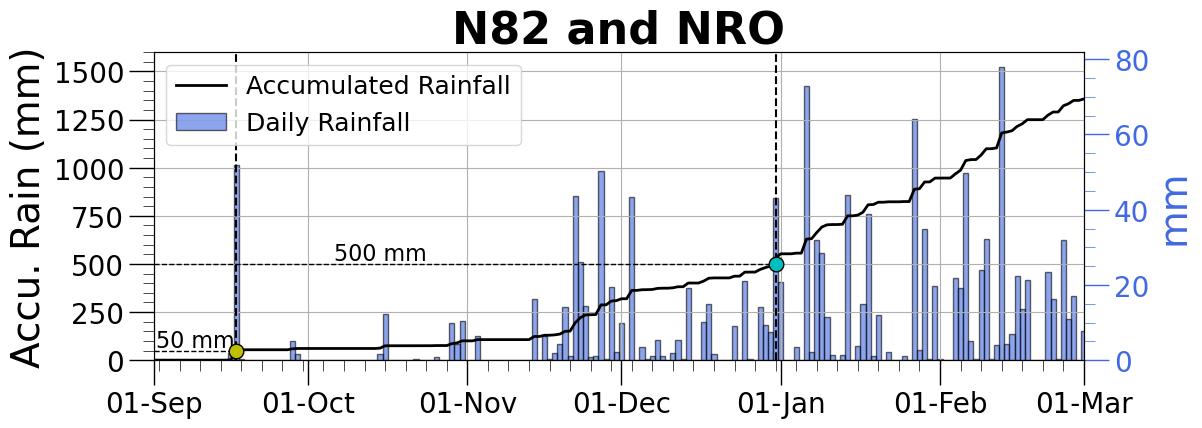

N82 monsoon onset date for 2024-2025: 2024-12-31 00:00:00
NRO monsoon onset date for 2024-2025: 2024-09-17 00:00:00


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np

# Loading the Darwin station rainfall
csv_file_path = "/g/data/dx2/rn0550/Green_Date/Late_Monsoon_Onset_Paper/DARWIN_NEW/Darwin_all_data_1941_2025.csv"

df = pd.read_csv(csv_file_path, low_memory=False)
df.columns = df.columns.str.strip()
date_col = "Day Month Year in DD/MM/YYYY format"
rain_col = "Precipitation in the 24 hours before 9am (local time) in mm"
df["Date"] = pd.to_datetime(df[date_col], dayfirst=True, errors="coerce")
df[rain_col] = pd.to_numeric(df[rain_col], errors="coerce")
df.dropna(subset=[rain_col], inplace=True)
df["Year"] = df["Date"].dt.year

year = 2024

######################################################################################################
start_date_500mm = pd.to_datetime(f"01-09-{year}", dayfirst=True)  
start_date_50mm = pd.to_datetime(f"01-09-{year}", dayfirst=True)  
end_date = pd.to_datetime(f"31-03-{year+1}", dayfirst=True)

df_season_500mm = df[(df["Date"] >= start_date_500mm) & (df["Date"] <= end_date)].copy()
df_season_50mm = df[(df["Date"] >= start_date_50mm) & (df["Date"] <= end_date)].copy()

df_season_500mm["Accumulated Rainfall"] = df_season_500mm[rain_col].cumsum()
df_season_50mm["Accumulated Rainfall"] = df_season_50mm[rain_col].cumsum()

threshold_500 = 500
first_500mm_date = df_season_500mm[df_season_500mm["Accumulated Rainfall"] >= threshold_500].get("Date", pd.Series()).min()

threshold_50 = 50
first_50mm_date = df_season_50mm[df_season_50mm["Accumulated Rainfall"] >= threshold_50].get("Date", pd.Series()).min()

######################################################################################################
# Plotting
fig, ax = plt.subplots(figsize=(12, 4))

ax2 = ax.twinx()
ax.set_zorder(2)  
ax2.set_zorder(1)  
ax.patch.set_visible(False)  
ax2.bar(df_season_500mm["Date"], df_season_500mm[rain_col], width=1, color='royalblue', edgecolor='black', alpha=0.6, label='Daily Rainfall', zorder=1)
ax.plot(df_season_500mm["Date"], df_season_500mm["Accumulated Rainfall"], label="Accumulated Rainfall", color="black", linewidth=2, zorder=2)

if pd.notna(first_500mm_date):
    ax.axvline(first_500mm_date, color="k", linestyle="--", linewidth=1.5)
    ax.scatter(first_500mm_date, 500, color="c", edgecolors="black", marker='o', s=110, zorder=4)
    #plt.text(first_500mm_date, 60, 
             #first_500mm_date.strftime('%d-%b-%Y'), 
             #color='k', fontsize=12, fontweight="bold", verticalalignment='bottom', horizontalalignment='right')


if first_500mm_date is not None:
    first_500mm_date = pd.to_datetime(first_500mm_date)
    ax.hlines(y=threshold_500, xmin=df_season_500mm["Date"].min(), xmax=first_500mm_date, 
              color='black', linestyle='--', linewidth=1)
else:
    ax.axhline(y=threshold_500, color='black', linestyle='--', linewidth=1)


if pd.notna(first_50mm_date):
    ax.axvline(first_50mm_date, color="k", linestyle="--", linewidth=1.5)
    ax.scatter(first_50mm_date, 50, color="y", edgecolors="black", marker='o', s=110, zorder=4)
    #plt.text(first_50mm_date, 60, 
             #first_50mm_date.strftime('%d-%b-%Y'), 
             #color='k', fontsize=12, fontweight="bold", verticalalignment='bottom', horizontalalignment='right')



if first_50mm_date is not None:
    first_50mm_date = pd.to_datetime(first_50mm_date)
    ax.hlines(y=threshold_50, xmin=df_season_50mm["Date"].min(), xmax=first_50mm_date, 
              color='black', linestyle='--', linewidth=1)
else:
    ax.axhline(y=threshold_50, color='black', linestyle='--', linewidth=1)


ax.text(df_season_500mm["Date"].min() + pd.Timedelta(days=35), threshold_500 + 20, "500 mm", color="k", fontsize=16, zorder=3)
ax.text(df_season_50mm["Date"].min() + pd.Timedelta(days=0.5), threshold_50 + 20, "50 mm", color="k", fontsize=16, zorder=3)
ax.set_ylabel("Accu. Rain (mm)", fontsize=28, color="k")
ax2.set_ylabel("mm", fontsize=28, color="royalblue")
ax.set_title("N82 and NRO", fontsize=32, fontweight="bold")
ax.tick_params(axis="x", rotation=45, labelsize=20)
ax.tick_params(axis="y", labelcolor="k", labelsize=20)  
ax2.tick_params(axis="y", labelcolor="royalblue", labelsize=20)  
ax2.minorticks_on()
xticks = pd.date_range(start=start_date_50mm, end=end_date, freq="1MS")
ax.set_xticks(xticks)
ax.set_xticklabels([date.strftime("%d-%b") for date in xticks], rotation=360, fontsize=20)
ax.minorticks_on()
ax.tick_params(axis="both", which="major", length=18, width=1)  
ax.tick_params(axis="both", which="minor", length=8, width=0.5)  
ax.xaxis.set_minor_locator(ticker.MultipleLocator(4)) 
ax.set_xlim(xticks[0], xticks[-1])
ax.set_ylim(0, 1600)
ax.set_yticks(np.arange(0, 1600, 250))

handles1, labels1 = ax.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()
handles = handles1 + handles2
labels = labels1 + labels2
ax.legend(handles, labels, loc="upper left", fontsize=18)

ax.grid()
ax2.tick_params(axis="both", which="minor", length=8, width=0.5, color="royalblue")  
ax2.tick_params(axis="both", which="major", length=18, width=1, color="royalblue")

plt.show()

#fig.savefig("/g/data/dx2/rn0550/Green_Date/Late_Monsoon_Onset_Paper/FIGURES/new_figs_station_data/5_Nicholls_1982_&_NRO_2024-2025.png", dpi=600, bbox_inches='tight')

print(f"N82 monsoon onset date for {year}-{year+1}: {first_500mm_date}")
print(f"NRO monsoon onset date for {year}-{year+1}: {first_50mm_date}")



## Darwin U21

Climatological mean rainfall at Darwin (1991-2020): 4.95 mm/day
Minima date:  2024-11-19 00:00:00  Value:  -565.6925604229614


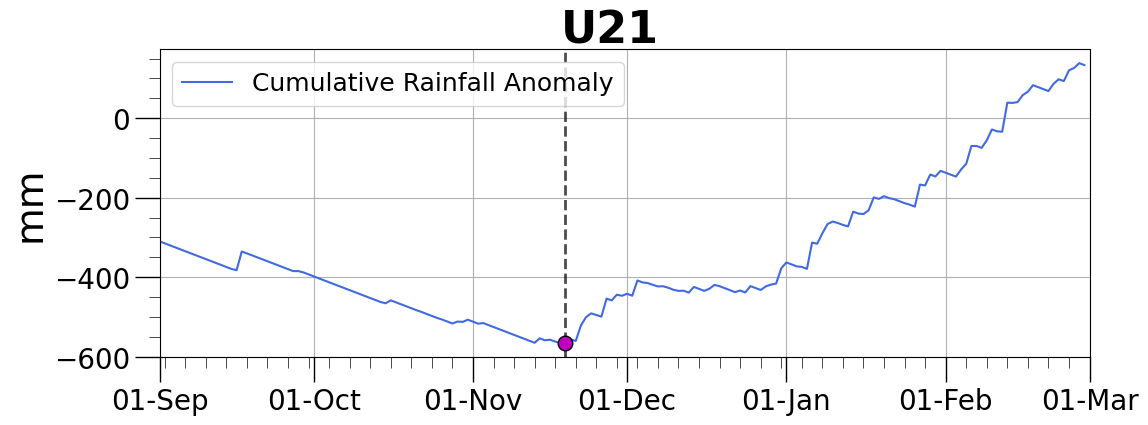

U21 monsoon onset date: 2024-11-19 00:00:00


In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.signal
import matplotlib.ticker as ticker
import matplotlib.dates as mdates

year_start, year_end = 2024, 2025
start_yr = 2024

start_date = pd.to_datetime(f'{start_yr}-07-01')
end_date = pd.to_datetime(f'{start_yr+1}-06-30')

# Loading the Darwin station rainfall
excel_file_path = "/g/data/dx2/rn0550/Green_Date/Late_Monsoon_Onset_Paper/DARWIN_NEW/Darwin_all_data_1941_2025.xls"
df_rain = pd.read_excel(excel_file_path, sheet_name='Sheet1', engine='xlrd') 
df_rain.columns = df_rain.columns.str.strip()
date_col = "Day Month Year in DD/MM/YYYY format"
rain_col = "Precipitation in the 24 hours before 9am (local time) in mm"
df_rain["Date"] = pd.to_datetime(df_rain[date_col], dayfirst=True, errors="coerce")
df_rain[rain_col] = pd.to_numeric(df_rain[rain_col], errors="coerce")
df_rain.rename(columns={rain_col: "Rainfall (mm/day)"}, inplace=True)
df_rain_filtered = df_rain[(df_rain["Date"] >= start_date) & (df_rain["Date"] <= end_date)]
darwin_rainfall = df_rain_filtered["Rainfall (mm/day)"]

######################################################################################################
# Calculating climatological mean (July 1 - June 30)
years_clim = np.arange(1991, 2020)  

df_rain_clim_all = pd.DataFrame()

for year in years_clim:
    start_date_clim = pd.to_datetime(f'{year}-07-01')
    end_date_clim = pd.to_datetime(f'{year+1}-06-30')
    df_rain_clim = df_rain[(df_rain["Date"] >= start_date_clim) & (df_rain["Date"] <= end_date_clim)]
    df_rain_clim_all = pd.concat([df_rain_clim_all, df_rain_clim])

climatological_mean_r = df_rain_clim_all["Rainfall (mm/day)"].mean()

print(f"Climatological mean rainfall at Darwin (1991-2020): {climatological_mean_r:.2f} mm/day")

######################################################################################################
# Calculating daily and cumulative anomalies
daily_anomaly = df_rain_filtered["Rainfall (mm/day)"] - climatological_mean_r
cumulative_anomaly = daily_anomaly.cumsum()

######################################################################################################
# Finding the local minima
dates = df_rain_filtered['Date'].tolist()  

cumulative_values = cumulative_anomaly.values  
minima_idx = scipy.signal.argrelextrema(cumulative_values, np.less, order=10)[0] 
true_min_idx = minima_idx[np.argmin(cumulative_values[minima_idx])]
minima_dates, minima_values = [dates[true_min_idx]], [cumulative_values[true_min_idx]]
print("Minima date: ", minima_dates[0], " Value: ", minima_values[0])

#########################################################################################################
# Plotting
fig, ax1 = plt.subplots(figsize=(12, 4))

ax1.plot(dates, cumulative_anomaly, color='royalblue', label="Cumulative Rainfall Anomaly")
ax1.set_ylabel("mm", color='k', fontsize=28)
ax1.tick_params(axis='y', labelcolor='k', labelsize=20)
ax1.tick_params(axis='x', labelcolor='k', labelsize=20)
ax1.scatter(minima_dates, minima_values, color='m', edgecolors="black", marker='o', zorder=3, s=110)

for date, value in zip(minima_dates, minima_values):
    ax1.axvline(date, color='k', linestyle="dashed", alpha=0.7, linewidth=2)
    #ax1.text(date, value+500, date.strftime('%d-%b-%Y'), color='k', fontsize=12, fontweight='bold', ha='right', va='bottom')

ax1.legend(loc="upper left", fontsize=18)
xticks = pd.date_range(start=f'{year_start}-09-01', end=f'{year_end}-03-01', freq='1MS')
ax1.set_xticks(xticks)
ax1.set_xticklabels([date.strftime('%d-%b') for date in xticks], rotation=360, fontsize=20)
ax1.minorticks_on()
ax1.tick_params(axis='both', which='major', length=18, width=1)  
ax1.tick_params(axis='both', which='minor', length=8, width=0.5)  
ax1.xaxis.set_minor_locator(ticker.MultipleLocator(4)) 
ax1.set_xlim(xticks[0], xticks[-1])

fig.suptitle("U21", fontsize=32, fontweight='bold')
plt.subplots_adjust(top=0.88)

plt.grid()
plt.show()

#fig.savefig("/g/data/dx2/rn0550/Green_Date/Late_Monsoon_Onset_Paper/FIGURES/new_figs_station_data/6_Uehling_2021_2024-2025.png", dpi=600, bbox_inches='tight')

print(f"U21 monsoon onset date: {date}")



## Darwin T61

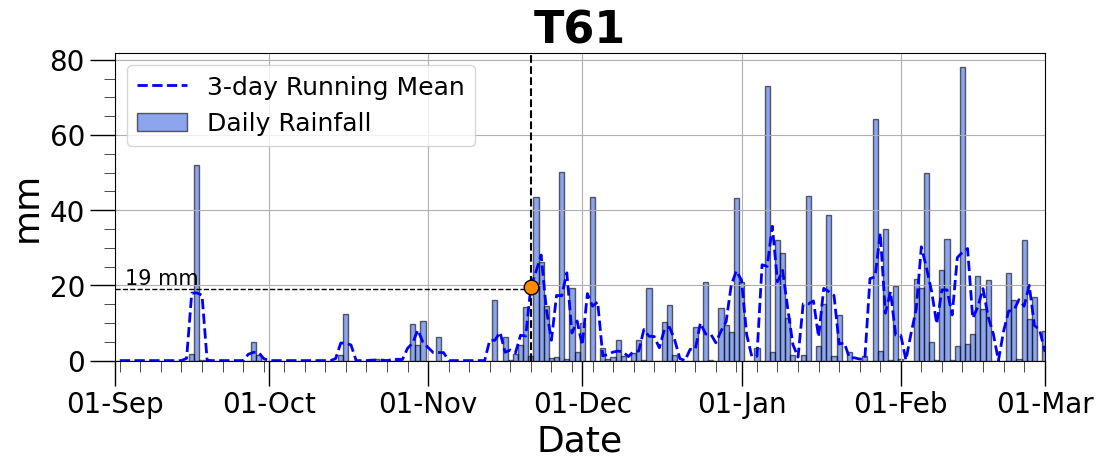

T61 monsoon onset date for 2024-2025: 2024-11-21 00:00:00


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

year = 2024  

# Loading the Darwin station rainfall
csv_file_path = "/g/data/dx2/rn0550/Green_Date/Late_Monsoon_Onset_Paper/DARWIN_NEW/Darwin_all_data_1941_2025.csv"
df = pd.read_csv(csv_file_path, low_memory=False)
df.columns = df.columns.str.strip()
date_col = "Day Month Year in DD/MM/YYYY format"
rain_col = "Precipitation in the 24 hours before 9am (local time) in mm"
df["Date"] = pd.to_datetime(df[date_col], dayfirst=True, errors="coerce")
df[rain_col] = pd.to_numeric(df[rain_col], errors="coerce")
df.dropna(subset=["Date", rain_col], inplace=True)
start_date = pd.to_datetime(f"01-09-{year}", dayfirst=True)  
end_date = pd.to_datetime(f"31-03-{year+1}", dayfirst=True)
season_df = df[(df["Date"] >= start_date) & (df["Date"] <= end_date)].copy()
season_df["Rain_3day_avg"] = season_df[rain_col].rolling(window=3, center=True).mean()

threshold = 19  
above_thresh = season_df["Rain_3day_avg"] > threshold
consec = above_thresh & above_thresh.shift(-1, fill_value=False)
onset_row = season_df.loc[consec].head(1)
onset_date = onset_row["Date"].values[0] if not onset_row.empty else None

#####################################################################################################################
# Plotting
fig, ax = plt.subplots(figsize=(12, 4))
avg_time_diff = np.mean(np.diff(season_df["Date"].values).astype('timedelta64[D]')).astype(int)

ax.bar(season_df["Date"], season_df[rain_col], width=avg_time_diff, 
       color='royalblue', edgecolor='black', alpha=0.6, label='Daily Rainfall')
ax.plot(season_df["Date"], season_df["Rain_3day_avg"], 'b--', linewidth=2, label='3-day Running Mean')
ax.text(season_df["Date"].min() + pd.Timedelta(days=2), threshold + 0.2, 
        f"{threshold} mm", color="k", fontsize=15, verticalalignment="bottom")

if onset_date is not None:
    onset_val = season_df.loc[season_df["Date"] == onset_date, "Rain_3day_avg"].values[0]
    ax.axvline(onset_date, color='black', linestyle='--', linewidth=1.5)
    ax.scatter(onset_date, onset_val, color='darkorange', edgecolors="black", marker='o', s=110, zorder=3)
    #ax.text(onset_date + pd.Timedelta(days=8), 20, f"{pd.to_datetime(onset_date).date()}", 
            #verticalalignment='bottom', horizontalalignment='right', fontsize=12, color='black', fontweight='bold')

if onset_date is not None:
    onset_date = pd.to_datetime(onset_date)
    ax.hlines(y=threshold, xmin=season_df["Date"].min(), xmax=onset_date, 
              color='black', linestyle='--', linewidth=1)
else:
    ax.axhline(y=threshold, color='black', linestyle='--', linewidth=1)

xticks = pd.date_range(start=start_date, end=end_date, freq='1MS')
ax.set_xticks(xticks, [date.strftime('%d-%b') for date in xticks], rotation=360, fontsize=20)
ax.set_xlim(xticks[0], xticks[-1])
ax.tick_params(axis='both', labelsize=20)
ax.minorticks_on()
ax.tick_params(axis='both', which='major', length=18, width=1)
ax.tick_params(axis='both', which='minor', length=8, width=0.5)
ax.xaxis.set_minor_locator(ticker.MultipleLocator(4))
ax.set_title("T61", fontsize=32, fontweight="bold")
ax.set_ylabel("mm", color="k", fontsize=26)
ax.set_xlabel("Date", fontsize=26)
plt.grid(True)
plt.legend(loc="upper left", fontsize=18)
plt.show()

#fig.savefig("/g/data/dx2/rn0550/Green_Date/Late_Monsoon_Onset_Paper/FIGURES/new_figs_station_data/8_Troupe_2024-2025.png", dpi=600, bbox_inches='tight')

print(f"T61 monsoon onset date for {year}-{year+1}: {onset_date}")



<span style="color:deeppink; font-size:35px;"><b>Fig. 4</b></span>

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should

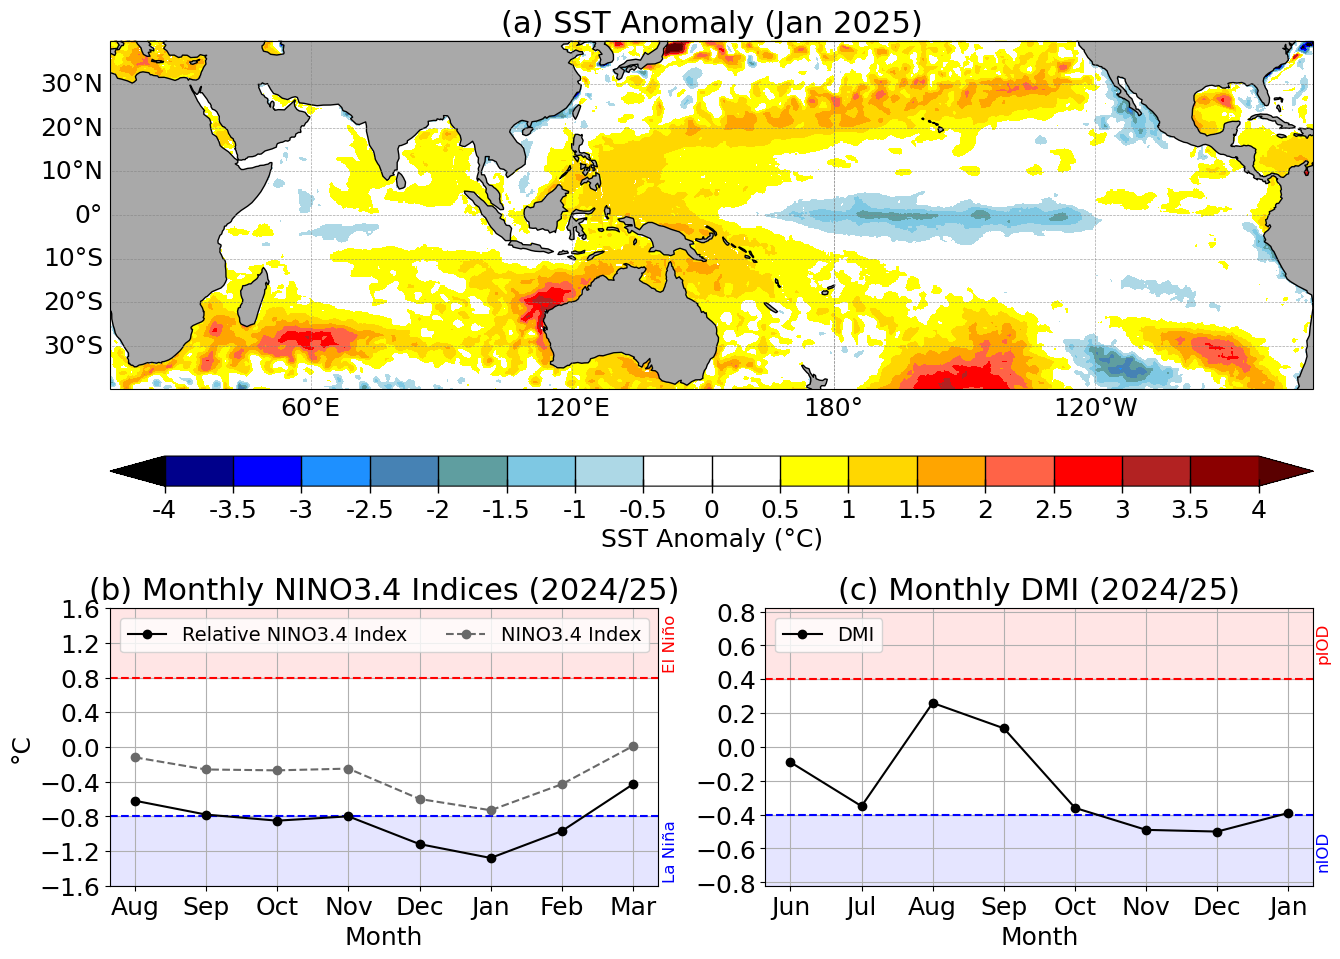

In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.colors as mcolors
import numpy as np
import pandas as pd
from docx import Document
import re
import matplotlib.gridspec as gridspec
import logging
logging.getLogger('flox').setLevel(logging.WARNING)

# ----------------------------------------
# Loading SST anomaly data for Jan 2025
# ----------------------------------------
sst_anom_ds = xr.open_dataset("/g/data/dx2/rn0550/Green_Date/ACCESS-S2_Ocean_Reanalysis/SST/sst_anomaly_january_2025_withclim_1991_2021.nc")
sst_anomaly = sst_anom_ds['sst']
lon = sst_anomaly['nav_lon']
lat = sst_anomaly['nav_lat']

clevs = [-4, -3.5, -3, -2.5, -2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4]
colors = [
    "#00008b", "#0000ff", "#1e90ff", "#4682b4", "#5f9ea0", "#7ec8e3", "#add8e6", "#ffffff", "#ffffff", 
    "#ffff00", "#ffd700", "#ffa500", "#ff6347", "#ff0000", "#b22222", "#8b0000"
]
cmap = mcolors.ListedColormap(colors)
norm = mcolors.BoundaryNorm(clevs, cmap.N)
cmap.set_under('black')
cmap.set_over('#5a0000')

# ----------------------------------------
# Loading RONI data - #from ERSSTv5 - https://www.cpc.ncep.noaa.gov/data/indices/
# ----------------------------------------
doc = Document("/g/data/dx2/rn0550/Green_Date/Late_Monsoon_Onset_Paper/RONI_monthly_1949_2025.docx") 
data = []
for para in doc.paragraphs:
    line = para.text.strip()
    match = re.match(r'^(\d{4})\s+(\d{1,2})\s+([-+]?\d*\.\d+|\d+)$', line)
    if match:
        yr, mth, anom = match.groups()
        data.append([int(yr), int(mth), float(anom)])
df = pd.DataFrame(data, columns=["YR", "MTH", "ANOM"])
df_2024 = df[(df["YR"] == 2024) & (df["MTH"] >= 8)]
df_2025 = df[(df["YR"] == 2025) & (df["MTH"] <= 3)]
df_selected = pd.concat([df_2024, df_2025]).sort_values(["YR", "MTH"])

# ----------------------------------------
# Loading NINO3.4 index from ERSSTv5 - #from ERSSTv5 - https://www.cpc.ncep.noaa.gov/products/analysis_monitoring/ensostuff/detrend.nino34.ascii.txt
# ----------------------------------------
doc_path = "/g/data/dx2/rn0550/Green_Date/Late_Monsoon_Onset_Paper/Climate_indices/Nino3.4_anom_ERSSTv5.docx"
doc = Document(doc_path)

lines = [p.text.strip() for p in doc.paragraphs if p.text.strip()]
data = []
for line in lines[1:]:  
    parts = line.split()
    if len(parts) == 5:
        year, mon, total, climadj, anom = parts
        data.append({
            "YR": int(year),
            "MON": int(mon),
            "TOTAL": float(total),
            "ClimAdjust": float(climadj),
            "ANOM": float(anom)
        })

df = pd.DataFrame(data)

df["time"] = pd.to_datetime(dict(year=df["YR"], month=df["MON"], day=1))
df = df.set_index("time")

nino34_anom = xr.DataArray(df["ANOM"], coords={"time": df.index}, dims="time")
nino34_anom.name = "Nino34_ersst"
nino34_sst_monthly = nino34_anom

# ----------------------------------------
# Loading DMI from ERSSTv5 - https://www.cpc.ncep.noaa.gov/products/international/ocean_monitoring/IODMI/mnth.ersstv5.clim19912020.dmi_current.txt
# ----------------------------------------
doc_path = "/g/data/dx2/rn0550/Green_Date/Late_Monsoon_Onset_Paper/Climate_indices/DMI_ERSSTv5.docx"
doc = Document(doc_path)

lines = [p.text.strip() for p in doc.paragraphs if p.text.strip()]

data = []
for line in lines:
    parts = line.split()
    if len(parts) == 5 and parts[0].isdigit():
        year, month, wtio, setio, dmi = parts
        data.append({
            "Year": int(year),
            "Month": int(month),
            "WTIO": float(wtio),
            "SETIO": float(setio),
            "DMI": float(dmi)
        })

df_dmi = pd.DataFrame(data)
df_dmi["time"] = pd.to_datetime(dict(year=df_dmi["Year"], month=df_dmi["Month"], day=1))
df_dmi = df_dmi.set_index("time")

dmi_sst_monthly = xr.DataArray(df_dmi["DMI"], coords={"time": df_dmi.index}, dims="time")
dmi_sst_monthly.name = "DMI_ersst"

################################################################################################################
start_date = "2024-08-01"
end_date = "2025-03-31"
start_date_dmi = "2024-06-01"
end_date_dmi = "2025-01-31"
nino34_selected_ersst = nino34_sst_monthly.sel(time=slice(start_date, end_date))
dmi_selected_ersst = dmi_sst_monthly.sel(time=slice(start_date_dmi, end_date_dmi))

month_labels_dt = pd.date_range(start="2024-08-01", end="2025-03-01", freq='MS')
month_labels_str = month_labels_dt.strftime("%b")
month_labels_dt_dmi = pd.date_range(start="2024-06-01", end="2025-01-01", freq='MS')
month_labels_str_dmi = mon1h_labels_dt_dmi.strftime("%b")

# ----------------------------------------
# Plotting
# ----------------------------------------
fig = plt.figure(figsize=(14, 10))
gs = gridspec.GridSpec(2, 2, height_ratios=[2, 1], width_ratios=[1, 1])

# Subplot (a) SSTa
ax1 = fig.add_subplot(gs[0, :], projection=ccrs.PlateCarree(central_longitude=180))
ax1.set_extent([14, 290, -40, 40], crs=ccrs.PlateCarree())
ax1.add_feature(cfeature.LAND, facecolor='darkgrey', zorder=1)
mesh = ax1.pcolormesh(lon, lat, sst_anomaly, transform=ccrs.PlateCarree(), cmap=cmap, norm=norm, shading='auto', zorder=0)
ax1.coastlines()
cbar = plt.colorbar(mesh, orientation="horizontal", pad=0.12, aspect=40, extend='both', ax=ax1)
cbar.set_label("SST Anomaly (°C)", fontsize=18)
cbar.set_ticks(clevs)
cbar.set_ticklabels([f"{c}" for c in clevs])
cbar.solids.set_edgecolor("face")
cbar.solids.set_linewidth(0.5)
cbar.ax.tick_params(axis='x', labelsize=18, length=10, width=1, direction='inout')
cbar.ax.grid(color='black', linewidth=1, linestyle='-')
ax1.set_title("(a) SST Anomaly (Jan 2025)", fontsize=22)
gl = ax1.gridlines(draw_labels=True, linestyle="--", linewidth=0.5, color="gray", alpha=0.7)
gl.top_labels = False
gl.right_labels = False
gl.xlabel_style = {"size": 18, "color": "black"}
gl.ylabel_style = {"size": 18, "color": "black"}

# Subplot (b) NINO3.4 and Relative NINO3.4
ax2 = fig.add_subplot(gs[1, 0])
ax2.axhspan(-1.6, -0.8, color='blue', alpha=0.1)
ax2.axhspan(0.8, 1.6, color='red', alpha=0.1)
ax2.axhline(y=-0.8, color='blue', linestyle='--', linewidth=1.5)
ax2.axhline(y=0.8, color='red', linestyle='--', linewidth=1.5)
ax2.text(x=1.01, y=1.2, s='El Niño', color='red', fontsize=12, va='center', rotation=90, transform=ax2.get_yaxis_transform())
ax2.text(x=1.01, y=-1.2, s='La Niña', color='blue', fontsize=12, va='center', rotation=90, transform=ax2.get_yaxis_transform())
ax2.plot(month_labels_str, df_selected["ANOM"].values, marker='o', linestyle='-', color='black', label="Relative NINO3.4 Index")
ax2.plot(month_labels_str, nino34_selected_ersst.values, marker='o', linestyle='--', color='dimgrey', label="NINO3.4 Index")
ax2.set_xticks(np.arange(len(month_labels_str)))
ax2.set_xticklabels(month_labels_str, fontsize=18)
ax2.set_ylabel("°C", fontsize=18)
ax2.set_xlabel("Month", fontsize=18)
ax2.tick_params(axis='y', labelsize=18)
ax2.set_title("(b) Monthly NINO3.4 Indices (2024/25)", fontsize=22)
ax2.set_ylim(-1.6, 1.6)
ax2.set_yticks(np.arange(-1.6, 1.61, 0.4)) 
ax2.grid(True)
ax2.legend(fontsize=14, ncols = 2, loc='upper left')

# Subplot (c) DMI
ax3 = fig.add_subplot(gs[1, 1])
ax3.axhspan(-0.82, -0.4, color='blue', alpha=0.1)
ax3.axhspan(0.4, 0.82, color='red', alpha=0.1)
ax3.axhline(y=-0.4, color='blue', linestyle='--', linewidth=1.5)
ax3.axhline(y=0.4, color='red', linestyle='--', linewidth=1.5)
ax3.text(x=2.2, y=1.2, s='pIOD', color='red', fontsize=12, va='center', rotation=90, transform=ax2.get_yaxis_transform())
ax3.text(x=2.2, y=-1.2, s='nIOD', color='blue', fontsize=12, va='center', rotation=90, transform=ax2.get_yaxis_transform())
ax3.plot(month_labels_str_dmi, dmi_selected_ersst.values, marker='o', linestyle='-', color='black', label="DMI")
ax3.set_xticks(np.arange(len(month_labels_str_dmi)))
ax3.set_xticklabels(month_labels_str_dmi, fontsize=18)
ax3.tick_params(axis='y', labelsize=18)
ax3.set_xlabel("Month", fontsize=18)
ax3.set_title("(c) Monthly DMI (2024/25)", fontsize=22)
ax3.set_ylim(-0.82, 0.82)
ax3.set_yticks(np.arange(-0.8, 0.81, 0.2)) 
ax3.grid(True)
ax3.legend(fontsize=14, loc='upper left')

plt.subplots_adjust(wspace=0.1)  
plt.tight_layout()

#plt.savefig("/g/data/dx2/rn0550/Green_Date/Late_Monsoon_Onset_Paper/FIGURES/SSTa_Jan_RelNINO34_NINO34_DMI_ERSST.png", dpi=600, bbox_inches='tight', format='png')

plt.show()




<span style="color:darkorange; font-size:35px;"><b>Suppl. Fig. 1</b></span>

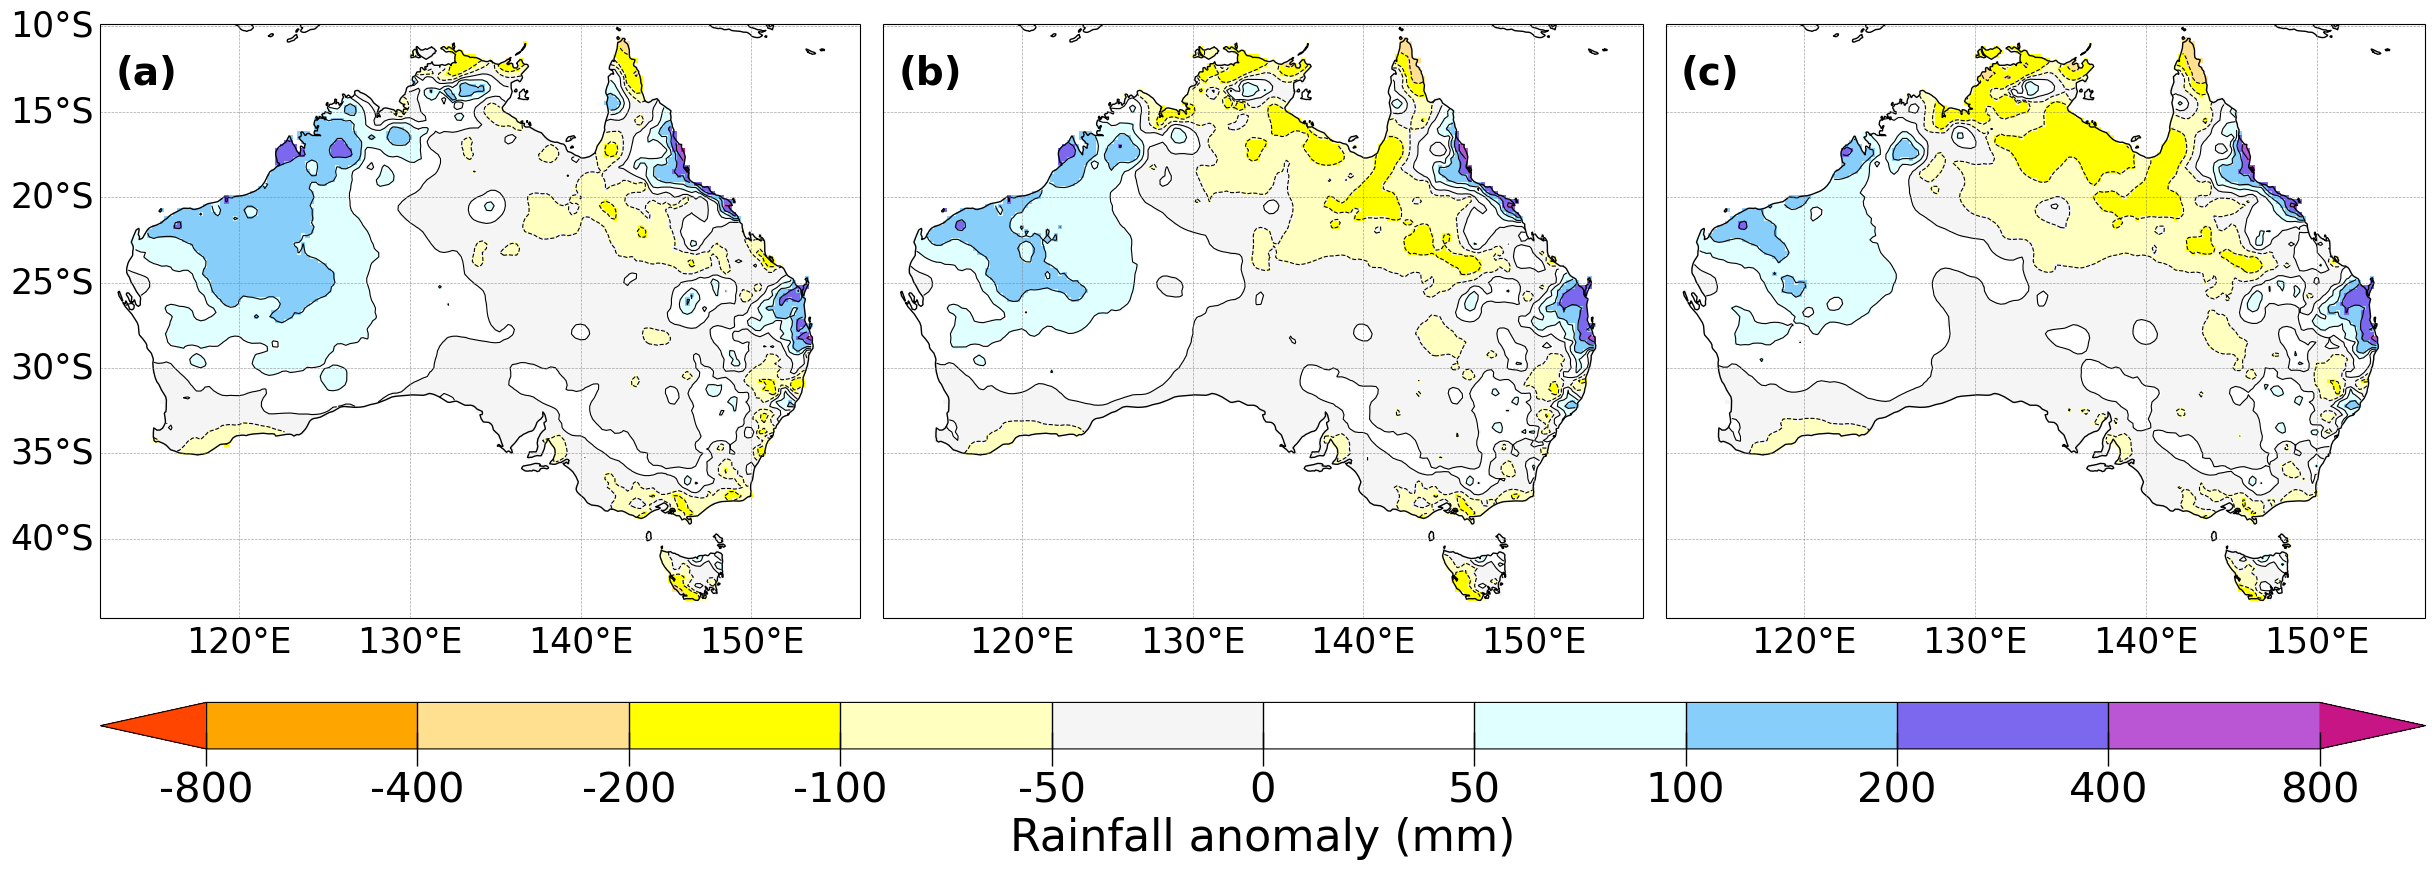

In [2]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.colors as mcolors
import matplotlib.gridspec as gridspec

clevs = [-800, -400, -200, -100, -50, 0, 50, 100, 200, 400, 800]
contour_levels = [-400, -200, -100, -50, 0, 50, 100, 200, 400]
colors = ["orange", "#fee090", "yellow", "#ffffbf", "whitesmoke","white",
          "lightcyan", "lightskyblue", "mediumslateblue", "mediumorchid"] 


cmap = mcolors.ListedColormap(colors)
norm = mcolors.BoundaryNorm(clevs, cmap.N)

cmap.set_under('#FF4500')
cmap.set_over('mediumvioletred')

labels = ['(a)', '(b)', '(c)']

# Loading rain anomaly based on different climatology files
anom_clim_1961_1990 = xr.open_dataset("/g/data/dx2/rn0550/Green_Date/Late_Monsoon_Onset_Paper/rain_clims/Oct-Jan_rain_anom_1961-1990clim.nc")
anom_clim_1981_2010 = xr.open_dataset("/g/data/dx2/rn0550/Green_Date/Late_Monsoon_Onset_Paper/rain_clims/Oct-Jan_rain_anom_1981-2010clim.nc")
anom_clim_1991_2020 = xr.open_dataset("/g/data/dx2/rn0550/Green_Date/Late_Monsoon_Onset_Paper/rain_clims/Oct-Jan_rain_anom_1991-2020clim.nc")
anom_1961_1990 = anom_clim_1961_1990['rainfallanomaly']
anom_1981_2010 = anom_clim_1981_2010['rainfallanomaly']
anom_1991_2020 = anom_clim_1991_2020['rainfallanomaly']

mask_ds = xr.open_dataset("/g/data/dx2/access-s2/calibration/reference/v1/aus_05_land_mask.nc")

# Landsea mask
land_mask = mask_ds["land"]  
land_mask = land_mask.interp(lat=anom_1961_1990.latitude, lon=anom_1961_1990.longitude)

#########################################################################################################
# Plotting
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(30, 20), subplot_kw={'projection': ccrs.PlateCarree()})
clim_periods = [(anom_1961_1990, "1961-1990"), (anom_1981_2010, "1981-2010"), (anom_1991_2020, "1991-2020")]

for i, (ax, (anom, title)) in enumerate(zip(axes, clim_periods)):    
    masked_anom = anom.mean(dim='time').where(land_mask == 1)
    im = ax.pcolormesh(anom.longitude, anom.latitude, masked_anom, 
                        cmap=cmap, norm=norm)
    
    contours = ax.contour(anom.longitude, anom.latitude, masked_anom, levels=contour_levels, 
                          colors='black', linewidths=0.8)

    ax.text(0.02, 0.95, labels[i], transform=ax.transAxes,
            fontsize=28, fontweight='bold', va='top', ha='left',
            bbox=dict(facecolor='white', edgecolor='none', alpha=0.8))

    gl = ax.gridlines(draw_labels=True, linestyle="--", linewidth=0.5, color="gray", alpha=0.7)
    gl.top_labels = False  
    gl.right_labels = False  

    if i != 0:
        gl.left_labels = False
        
    gl.xlabel_style = {"size": 25, "color": "black"}  
    gl.ylabel_style = {"size": 25, "color": "black"}  
    
    ax.coastlines()
    ax.add_feature(cfeature.BORDERS, linestyle=":")

plt.subplots_adjust(wspace=0.03, hspace=0.05) 

cbar = fig.colorbar(im, ax=axes.ravel().tolist(), orientation="horizontal", pad=0.12, aspect=50, extend = 'both')
pos = cbar.ax.get_position()
cbar.ax.set_position([pos.x0, pos.y0 + 0.05, pos.width, pos.height])
cbar.set_label("Rainfall anomaly (mm)", fontsize=32)
cbar.set_ticks(clevs)
cbar.set_ticklabels([f"{c}" for c in clevs], fontsize=30)
cbar.ax.xaxis.set_tick_params(width=1, color='black')  
cbar.ax.grid(color='black', linewidth=1, linestyle='-')  
cbar.ax.tick_params(axis='x', labelsize=30, length=24, width=1, direction='inout')  


#fig.savefig("/g/data/dx2/rn0550/Green_Date/Late_Monsoon_Onset_Paper/FIGURES/Rainfall_Anomaly_diff_clims.png", dpi=1000, bbox_inches='tight')


plt.show()



<span style="color:darkorange; font-size:35px;"><b>Suppl. Fig. 2</b></span>

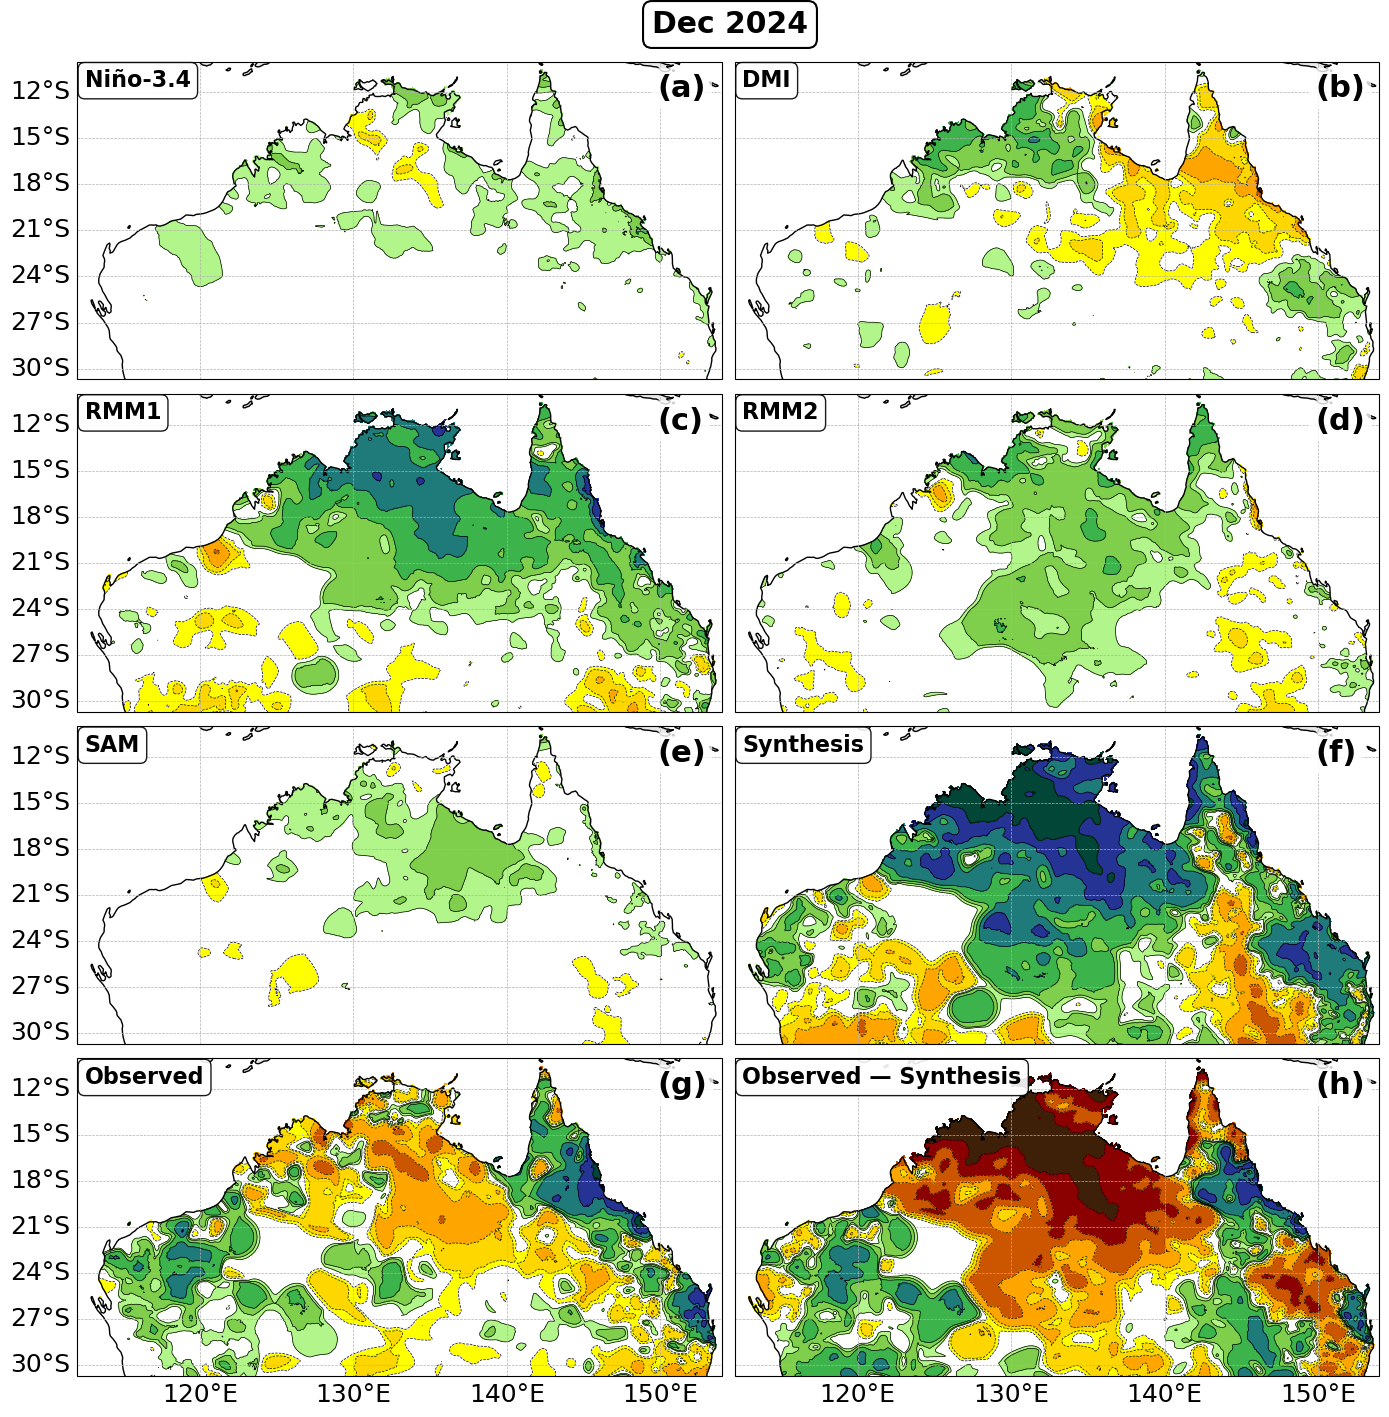

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import cartopy.crs as ccrs
import xarray as xr
import statsmodels.api as sm
import pandas as pd
import cartopy.feature as cfeature
from eofs.xarray import Eof
import matplotlib.colors as mcolors
from docx import Document
import pandas as pd
import string
from datetime import datetime
import calendar
import scipy.signal

# AGCD rainfall data path
file_path_rainfall = "/g/data/dx2/rn0550/Green_Date/Late_Monsoon_Onset_Paper/AGCD_rainfall_monthly_1981_2025.nc"

# Landsea mask
mask_ds = xr.open_dataset("/g/data/dx2/access-s2/calibration/reference/v1/aus_05_land_mask.nc")
land_mask = mask_ds["land"]  

ds_rainfall = xr.open_dataset(file_path_rainfall)

lat = ds_rainfall['lat'].values  
lon = ds_rainfall['lon'].values  
rainfall = ds_rainfall['precip']

land_mask = land_mask.assign_coords({
    "lat": rainfall["lat"],
    "lon": rainfall["lon"]
})

rainfall = ds_rainfall['precip'].where(land_mask == 1)

##################################################################################################################
# Loading RMM data
file_path_rmm = "/g/data/dx2/rn0550/Green_Date/Late_Monsoon_Onset_Paper/Climate_indices/rmm.74toRealtime.txt"

df_rmm = pd.read_csv(file_path_rmm, sep="\s+", skiprows=2, header=None, usecols=range(7))
df_rmm.columns = ["year", "month", "day", "RMM1", "RMM2", "phase", "amplitude"]
df_rmm["time"] = pd.to_datetime(df_rmm[["year", "month", "day"]])
df_rmm = df_rmm.set_index("time")
ds_rmm = xr.Dataset.from_dataframe(df_rmm[["RMM1", "RMM2"]])
ds_rmm_monthly = ds_rmm.resample(time="1MS").mean()

##################################################################################################################
# ----------------------------------------
# Load NINO3.4 index from ERSSTv5 - #from ERSSTv5 - https://www.cpc.ncep.noaa.gov/products/analysis_monitoring/ensostuff/detrend.nino34.ascii.txt
# ----------------------------------------
doc_path = "/g/data/dx2/rn0550/Green_Date/Late_Monsoon_Onset_Paper/Climate_indices/Nino3.4_anom_ERSSTv5.docx"
doc = Document(doc_path)

lines = [p.text.strip() for p in doc.paragraphs if p.text.strip()]

data = []
for line in lines[1:]: 
    parts = line.split()
    if len(parts) == 5:
        year, mon, total, climadj, anom = parts
        data.append({
            "YR": int(year),
            "MON": int(mon),
            "TOTAL": float(total),
            "ClimAdjust": float(climadj),
            "ANOM": float(anom)
        })

df = pd.DataFrame(data)
df["time"] = pd.to_datetime(dict(year=df["YR"], month=df["MON"], day=1))
df = df.set_index("time")

nino34_anom = xr.DataArray(df["ANOM"], coords={"time": df.index}, dims="time")
nino34_sst_norm = nino34_anom

##################################################################################################################
# ----------------------------------------
# Load DMI from ERSSTv5 - https://www.cpc.ncep.noaa.gov/products/international/ocean_monitoring/IODMI/mnth.ersstv5.clim19912020.dmi_current.txt
# ----------------------------------------
doc_path = "/g/data/dx2/rn0550/Green_Date/Late_Monsoon_Onset_Paper/Climate_indices/DMI_ERSSTv5.docx"
doc = Document(doc_path)

lines = [p.text.strip() for p in doc.paragraphs if p.text.strip()]

data = []
for line in lines:
    parts = line.split()
    if len(parts) == 5 and parts[0].isdigit():
        year, month, wtio, setio, dmi = parts
        data.append({
            "Year": int(year),
            "Month": int(month),
            "WTIO": float(wtio),
            "SETIO": float(setio),
            "DMI": float(dmi)
        })

df_dmi = pd.DataFrame(data)
df_dmi["time"] = pd.to_datetime(dict(year=df_dmi["Year"], month=df_dmi["Month"], day=1))
df_dmi = df_dmi.set_index("time")
dmi_sst_norm = xr.DataArray(df_dmi["DMI"], coords={"time": df_dmi.index}, dims="time")

##################################################################################################################
# ----------------------------------------
# Load SAM - https://ftp.cpc.ncep.noaa.gov/cwlinks/norm.daily.aao.index.b790101.current.ascii
# ----------------------------------------
doc = Document("/g/data/dx2/rn0550/Green_Date/Late_Monsoon_Onset_Paper/Climate_indices/SAM_index_1979_2025.docx")

data = []
for para in doc.paragraphs:
    parts = para.text.strip().split()
    if len(parts) == 4:
        try:
            year, month, day = map(int, parts[:3])
            sam = float(parts[3])
            data.append([year, month, day, sam])
        except ValueError:
            continue  

df_sam = pd.DataFrame(data, columns=["year", "month", "day", "SAM"])
df_sam["time"] = pd.to_datetime(df_sam[["year", "month", "day"]], errors="coerce")
df_sam = df_sam.set_index("time").dropna()
sam_monthly = df_sam.resample("1MS").mean()
sam_monthly = sam_monthly.to_xarray()

##################################################################################################################
##################################################################################################################
# Defining the training period
rainfall_dec_list = []
nino34_dec_list = []
dmi_dec_list = []
rmm1_dec_list = []
rmm2_dec_list = []
sam_dec_list = []

day1 = '01'
day2 = '31'
month = '12' #'01'
target_year = '2024' #'2025'

month_name = calendar.month_abbr[int(month)]
mon_title = f"{month_name} {target_year}"

climprd1 = 1991  
climprd2 = 2021  

for year in range(climprd1, climprd2):
    rainfall_dec = rainfall.sel(time=slice(f"{year}-{month}-{day1}", f"{year}-{month}-{day2}"))
    rainfall_dec_list.append(rainfall_dec)
    
    nino34_dec = nino34_sst_norm.sel(time=slice(f"{year}-{month}-{day1}", f"{year}-{month}-{day2}"))
    dmi_dec = dmi_sst_norm.sel(time=slice(f"{year}-{month}-{day1}", f"{year}-{month}-{day2}"))
    rmm1_dec = ds_rmm_monthly['RMM1'].sel(time=slice(f"{year}-{month}-{day1}", f"{year}-{month}-{day2}"))
    rmm2_dec = ds_rmm_monthly['RMM2'].sel(time=slice(f"{year}-{month}-{day1}", f"{year}-{month}-{day2}"))
    sam_dec = sam_monthly['SAM'].sel(time=slice(f"{year}-{month}-{day1}", f"{year}-{month}-{day2}"))

    nino34_dec_list.append(nino34_dec)
    dmi_dec_list.append(dmi_dec)
    rmm1_dec_list.append(rmm1_dec)
    rmm2_dec_list.append(rmm2_dec)
    sam_dec_list.append(sam_dec)

rainfall_training_period = xr.concat(rainfall_dec_list, dim="time")
nino34_sst_training = xr.concat(nino34_dec_list, dim="time")
dmi_sst_training = xr.concat(dmi_dec_list, dim="time")
rmm1_training = xr.concat(rmm1_dec_list, dim="time")
rmm2_training = xr.concat(rmm2_dec_list, dim="time")
sam_training = xr.concat(sam_dec_list, dim="time").squeeze()

rainfall_climatology = rainfall_training_period.mean(dim='time')
rainfall_anomaly = rainfall_training_period - rainfall_climatology

climate_indices = xr.Dataset({
    "Nino34": nino34_sst_training,
    "DMI": dmi_sst_training,
    "RMM1": rmm1_training,
    "RMM2": rmm2_training,
    "SAM_index": sam_training
})

########################################################################################################################
# Detrending the data
def detrend_dim(da, dim='time'):
    return xr.apply_ufunc(
        scipy.signal.detrend, da,
        kwargs={'axis': -1, 'type': 'linear'},
        input_core_dims=[[dim]],
        output_core_dims=[[dim]],
        vectorize=True
    )

climate_indices_detrended = climate_indices.copy()
for var in climate_indices.data_vars:
    climate_indices_detrended[var] = detrend_dim(climate_indices[var])

########################################################################################################################
# Calculating mean and std dev for each predictor over the training period
predictor_means = climate_indices_detrended.mean(dim='time')
predictor_stds = climate_indices_detrended.std(dim='time')

mean_nino34 = predictor_means['Nino34'].item()
std_nino34 = predictor_stds['Nino34'].item()

mean_dmi = predictor_means['DMI'].item()
std_dmi = predictor_stds['DMI'].item()

mean_rmm1 = predictor_means['RMM1'].item()
std_rmm1 = predictor_stds['RMM1'].item()

mean_rmm2 = predictor_means['RMM2'].item()
std_rmm2 = predictor_stds['RMM2'].item()

mean_sam = predictor_means['SAM_index'].item()
std_sam = predictor_stds['SAM_index'].item()

##############################################################################################################################
##############################################################################################################################
##############################################################################################################################
# Calculating the observed total rainfall anomaly:
observed_rainfall_2024_2025 = rainfall.sel(time=slice(f'{target_year}-{month}-{day1}', f'{target_year}-{month}-{day2}'))
total_rainfall_2024_2025 = observed_rainfall_2024_2025.sum(dim='time')
observed_rainfall_anomaly_2024_2025 = (total_rainfall_2024_2025 - rainfall_climatology).where(land_mask == 1)

##############################################################################################################
##############################################################################################################
# Synthesizing the rainfall anomaly for the training period:
n_time = rainfall_anomaly.shape[0]  
n_lat = rainfall_anomaly.shape[1]   
n_lon = rainfall_anomaly.shape[2]   

rainfall_anomaly_flat = rainfall_anomaly.values.reshape(n_time, -1)  

nino34_flat = nino34_sst_training.values  
dmi_flat = dmi_sst_training.values  
rmm1_flat = rmm1_training.values  
rmm2_flat = rmm2_training.values  
sam_flat = sam_training.values  

df_train = pd.DataFrame({
    "Nino34": nino34_flat,
    "iod_index": dmi_flat,
    "RMM1": rmm1_flat,
    "RMM2": rmm2_flat,
    "SAM_index": sam_flat
})


df_train = df_train.apply(pd.to_numeric, errors='coerce')
valid_mask = df_train.notnull().all(axis=1)
df_train = df_train[valid_mask]
rainfall_anomaly_flat = rainfall_anomaly_flat[valid_mask.values, :]

model = sm.OLS(rainfall_anomaly_flat, df_train)
results = model.fit()

# Extracting the regression coefficients (b(i) for each predictor)
b_coefficients = results.params  
b_nino34 = b_coefficients.loc['Nino34'].values.reshape(n_lat, n_lon)
b_dmi = b_coefficients.loc['iod_index'].values.reshape(n_lat, n_lon)
b_rmm1 = b_coefficients.loc['RMM1'].values.reshape(n_lat, n_lon)
b_rmm2 = b_coefficients.loc['RMM2'].values.reshape(n_lat, n_lon)
b_sam = b_coefficients.loc['SAM_index'].values.reshape(n_lat, n_lon)

#########################################################################################################################
# Computing synthesized rainfall anomaly for the training period [ŷ(𝑡) = Σ𝑏(𝑖)𝑥(𝑖,𝑡)]

rainfall_synthesis_training = (
    b_nino34.ravel() * nino34_flat[:, None] + 
    b_dmi.ravel() * dmi_flat[:, None] +
    b_rmm1.ravel() * rmm1_flat[:, None] +
    b_rmm2.ravel() * rmm2_flat[:, None] +
    b_sam.ravel() * sam_flat[:, None]
)

rainfall_synthesis_training = rainfall_synthesis_training.reshape(n_time, n_lat, n_lon)
time_values = rainfall_training_period.coords['time']
rainfall_synthesis_training = xr.DataArray(rainfall_synthesis_training, 
                                           coords=[time_values, lat, lon], 
                                           dims=["time", "lat", "lon"])

#########################################################################################################################
#########################################################################################################################
#########################################################################################################################
# Computing synthesized rainfall anomaly for the target period [ŷ(2024-2025)= Σ𝑏(𝑖)𝑥(𝑖,2024-2025)]
# Loading predictor values 
nino34_2024_2025 = nino34_sst_norm.sel(time=slice(f"{target_year}-{month}-{day1}", f"{target_year}-{month}-{day2}")).values  
dmi_2024_2025 = dmi_sst_norm.sel(time=slice(f"{target_year}-{month}-{day1}", f"{target_year}-{month}-{day2}")).values  
rmm1_2024_2025 = ds_rmm_monthly['RMM1'].sel(time=slice(f"{target_year}-{month}-{day1}", f"{target_year}-{month}-{day2}")).values  
rmm2_2024_2025 = ds_rmm_monthly['RMM2'].sel(time=slice(f"{target_year}-{month}-{day1}", f"{target_year}-{month}-{day2}")).values 
sam_2024_2025 = sam_monthly['SAM'].sel(time=slice(f"{target_year}-{month}-{day1}", f"{target_year}-{month}-{day2}")).values 

# Standardizing the target predictors using training-period mean and std
nino34_2024_2025_std = (nino34_2024_2025 - mean_nino34) / std_nino34
dmi_2024_2025_std = (dmi_2024_2025 - mean_dmi) / std_dmi
rmm1_2024_2025_std = (rmm1_2024_2025 - mean_rmm1) / std_rmm1
rmm2_2024_2025_std = (rmm2_2024_2025 - mean_rmm2) / std_rmm2
sam_2024_2025_std = (sam_2024_2025 - mean_sam) / std_sam

rainfall_synthesis_2024_2025 = (
    b_nino34.ravel() * nino34_2024_2025_std[:, None] + 
    b_dmi.ravel() * dmi_2024_2025_std[:, None] +
    b_rmm1.ravel() * rmm1_2024_2025_std[:, None] +
    b_rmm2.ravel() * rmm2_2024_2025_std[:, None] +
    b_sam.ravel() * sam_2024_2025_std[:, None]
)


rainfall_synthesis_2024_2025 = rainfall_synthesis_2024_2025.reshape(n_lat, n_lon)

##############################################################################################################################
rainfall_synthesis_total = rainfall_synthesis_2024_2025  
rainfall_synthesis_total = xr.DataArray(rainfall_synthesis_total, 
                                        coords=[lat, lon], 
                                        dims=["lat", "lon"])

# Landsea mask
mask_ds = xr.open_dataset("/g/data/dx2/access-s2/calibration/reference/v1/aus_05_land_mask.nc")
land_mask = mask_ds["land"]  

land_mask = land_mask.assign_coords({
    "lat": rainfall_synthesis_total["lat"],
    "lon": rainfall_synthesis_total["lon"]
})

rainfall_synthesis_total_masked = rainfall_synthesis_total.where(land_mask == 1)

##############################################################################################################################
##############################################################################################################################
##############################################################################################################################
# Calculating the drivers' contributions
rainfall_synthesis_nino34 = b_nino34 * nino34_2024_2025 
rainfall_synthesis_dmi = b_dmi * dmi_2024_2025 
rainfall_synthesis_rmm1 = b_rmm1 * rmm1_2024_2025 
rainfall_synthesis_rmm2 = b_rmm2 * rmm2_2024_2025
rainfall_synthesis_sam = b_sam * sam_2024_2025 

rainfall_synthesis_nino34_total = rainfall_synthesis_nino34
rainfall_synthesis_dmi_total = rainfall_synthesis_dmi
rainfall_synthesis_rmm1_total = rainfall_synthesis_rmm1
rainfall_synthesis_rmm2_total = rainfall_synthesis_rmm2
rainfall_synthesis_sam_total = rainfall_synthesis_sam

rainfall_synthesis_nino34_total = xr.DataArray(rainfall_synthesis_nino34, coords=[lat, lon], dims=["lat", "lon"])
rainfall_synthesis_dmi_total = xr.DataArray(rainfall_synthesis_dmi, coords=[lat, lon], dims=["lat", "lon"])
rainfall_synthesis_rmm1_total = xr.DataArray(rainfall_synthesis_rmm1, coords=[lat, lon], dims=["lat", "lon"])
rainfall_synthesis_rmm2_total = xr.DataArray(rainfall_synthesis_rmm2, coords=[lat, lon], dims=["lat", "lon"])
rainfall_synthesis_sam_total = xr.DataArray(rainfall_synthesis_sam, coords=[lat, lon], dims=["lat", "lon"])

rainfall_synthesis_nino34_total_masked = rainfall_synthesis_nino34_total.where(land_mask == 1)
rainfall_synthesis_dmi_total_masked = rainfall_synthesis_dmi_total.where(land_mask == 1)
rainfall_synthesis_rmm1_total_masked = rainfall_synthesis_rmm1_total.where(land_mask == 1)
rainfall_synthesis_rmm2_total_masked = rainfall_synthesis_rmm2_total.where(land_mask == 1)
rainfall_synthesis_sam_total_masked = rainfall_synthesis_sam_total.where(land_mask == 1)

##################################################################################################################
##################################################################################################################
##################################################################################################################
# Plotting
lim = 320
ncolrs = 13
levels = np.array([-320, -160, -80, -40, -20, -10, 0, 10, 20, 40, 80, 160, 320])
levels_cnt = np.array([-320, -160, -80, -40, -20, -10, 10, 20, 40, 80, 160, 320])

colors = [
    "#8b0000", "#cc5500", "#ffa500", "#ffd700", "#ffff00", 
    "#ffffff", "#ffffff",
    "#b2f68b", "#7fcf4d", "#3cb44b", "#1f7a7a", "#253494" 
]

cmap = mcolors.LinearSegmentedColormap.from_list("custom_div", colors, N=len(levels)-1)
norm = mcolors.BoundaryNorm(boundaries=levels, ncolors=len(levels)-1)
cmap.set_over("#014636")
cmap.set_under("#3e1f08")

def plot_map(ax, data, title, lon, lat):
    ax.set_extent([112, 154, -29, -10])  
    im = ax.contourf(lon, lat, data, levels=levels, cmap=cmap, norm=norm, extend='both')
    ax.contour(lon, lat, data, levels=levels_cnt, colors='black', linewidths=0.5)
    ax.add_feature(cfeature.COASTLINE, linewidth=1)
    ax.add_feature(cfeature.BORDERS, linestyle=':')
    ax.add_feature(cfeature.LAND, color='lightgrey', alpha=0.5)
    
    return im  

fig, axes = plt.subplots(4, 2, figsize=(14, 16), subplot_kw={'projection': ccrs.PlateCarree()})

difference = observed_rainfall_anomaly_2024_2025 - rainfall_synthesis_total_masked

plot_data = [
    (rainfall_synthesis_nino34_total_masked, "Niño-3.4"),
    (rainfall_synthesis_dmi_total_masked, "DMI"),
    (rainfall_synthesis_rmm1_total_masked, "RMM1"),
    (rainfall_synthesis_rmm2_total_masked, "RMM2"),
    (rainfall_synthesis_sam_total_masked, "SAM"),
    (rainfall_synthesis_total_masked, "Synthesis"),
    (observed_rainfall_anomaly_2024_2025, "Observed"),
    (difference, "Observed — Synthesis")
]

labels = list(string.ascii_lowercase)  # For Dec
#labels = list(string.ascii_lowercase[string.ascii_lowercase.index("i"):]) # For Jan

for i, (data, title) in enumerate(plot_data):
    row, col = divmod(i, 2)  
    ax = axes[row, col]
    im = plot_map(ax, data, title, lon, lat)  
    ax.text(
        0.012, 0.976, title,
        transform=ax.transAxes,
        fontsize=16, fontweight='bold',
        va='top', ha='left',
        bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="black", lw=1, alpha=0.9)
    )

    label = f"({labels[i]})"
    ax.text(
        0.9, 0.96, label, transform=ax.transAxes,
        fontsize=22, fontweight='bold', va='top', ha='left',
        bbox=dict(boxstyle="round,pad=0.2", fc="white", ec="none", alpha=0.8)
    )

if len(plot_data) < 8:  
    fig.delaxes(axes[3, 1])

for row in range(4):
    for col in range(2):
        ax = axes[row, col]
        gl = ax.gridlines(draw_labels=True, linestyle="--", linewidth=0.5)
        gl.left_labels = (col == 0)
        gl.right_labels = False
        gl.bottom_labels = (row == 3)
        gl.top_labels = False
        gl.xlabel_style = {"size": 18, "color": "black"}
        gl.ylabel_style = {"size": 18, "color": "black"}

plt.tight_layout(rect=[0, 0.05, 1, 1])  

plt.subplots_adjust(
    wspace=0.02,  
    hspace=-0.3  
)

fig.text(
    0.525, 0.9738, f"{mon_title}",
    ha='center', va='top',
    fontsize=21.5, fontweight='bold',
    bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="black", lw=1.5)
)

#plt.savefig(f"/g/data/dx2/rn0550/Green_Date/Late_Monsoon_Onset_Paper/FIGURES/MLR_maps/Synthetic_Total_Rainfall_Multiple_Linear_Regression_Climate_Modes_({mon_title})_only_clim_{climprd1}_{climprd2-1}_without_intercept_detrended_and_scaled_ERSST.png", dpi=400, bbox_inches='tight', format='png')

plt.show()



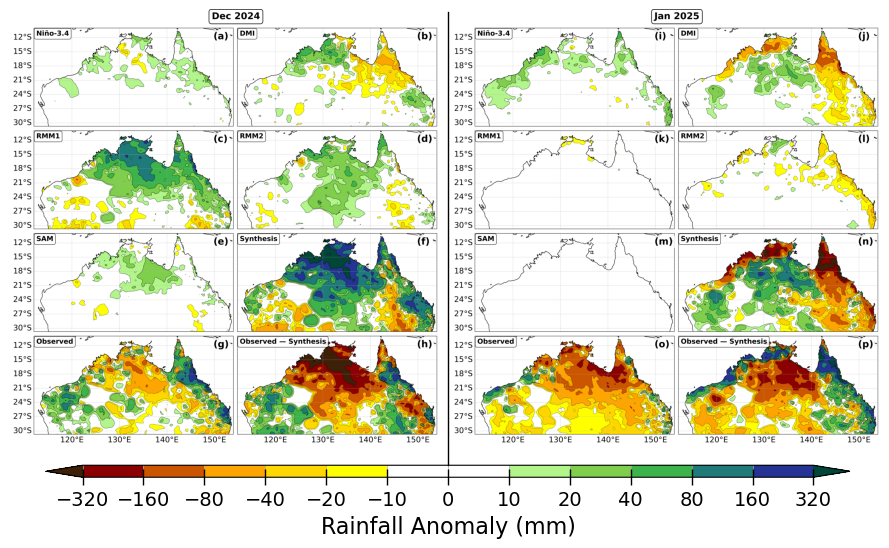

In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.colors as mcolors
import numpy as np
from matplotlib.cm import ScalarMappable

climprd1 = 1991
climprd2 = 2020

# File paths and reading the images
path_dec = f"/g/data/dx2/rn0550/Green_Date/Late_Monsoon_Onset_Paper/FIGURES/MLR_maps/Synthetic_Total_Rainfall_Multiple_Linear_Regression_Climate_Modes_(Dec 2024)_only_clim_{climprd1}_{climprd2}_without_intercept_detrended_and_scaled_ERSST.png"
path_jan = f"/g/data/dx2/rn0550/Green_Date/Late_Monsoon_Onset_Paper/FIGURES/MLR_maps/Synthetic_Total_Rainfall_Multiple_Linear_Regression_Climate_Modes_(Jan 2025)_only_clim_{climprd1}_{climprd2}_without_intercept_detrended_and_scaled_ERSST.png"

img_dec = mpimg.imread(path_dec)
img_jan = mpimg.imread(path_jan)

# Plotting
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

axs[0].imshow(img_dec)
axs[0].axis('off')
axs[1].imshow(img_jan)
axs[1].axis('off')

plt.subplots_adjust(wspace=-0.1, bottom=0.15)
levels = np.array([-320, -160, -80, -40, -20, -10, 0, 10, 20, 40, 80, 160, 320])

colors = [
    "#8b0000", "#cc5500", "#ffa500", "#ffd700", "#ffff00", 
    "#ffffff", "#ffffff",
    "#b2f68b", "#7fcf4d", "#3cb44b", "#1f7a7a", "#253494" 
]

cmap = mcolors.LinearSegmentedColormap.from_list("custom_div", colors, N=len(levels)-1)
norm = mcolors.BoundaryNorm(boundaries=levels, ncolors=len(levels)-1)
cmap.set_over("#014636")
cmap.set_under("#3e1f08")

sm = ScalarMappable(cmap=cmap, norm=norm)

cax = fig.add_axes([0.18, 0.1, 0.67, 0.02]) 

cbar = fig.colorbar(sm, cax=cax, orientation="horizontal", extend="both")
cbar.set_label("Rainfall Anomaly (mm)", fontsize=16)
cbar.set_ticks(levels)
cbar.ax.tick_params(axis='x', labelsize=14, length=12, width=1, direction='inout')
cbar.ax.grid(color='darkgrey', linewidth=0.5, linestyle='-')

line_x = 0.515  
fig.add_artist(plt.Line2D([line_x, line_x], [0.12, 0.875], transform=fig.transFigure, color='black', linewidth=1))

#plt.savefig(f"/g/data/dx2/rn0550/Green_Date/Late_Monsoon_Onset_Paper/FIGURES/MLR_maps/Combined_DEC_JAN_MLR_clim_{climprd1}_{climprd2}_detrended_and_without_intercept.png", dpi=800)
plt.show()




<span style="color:darkorange; font-size:35px;"><b>Suppl. Fig. 3</b></span>

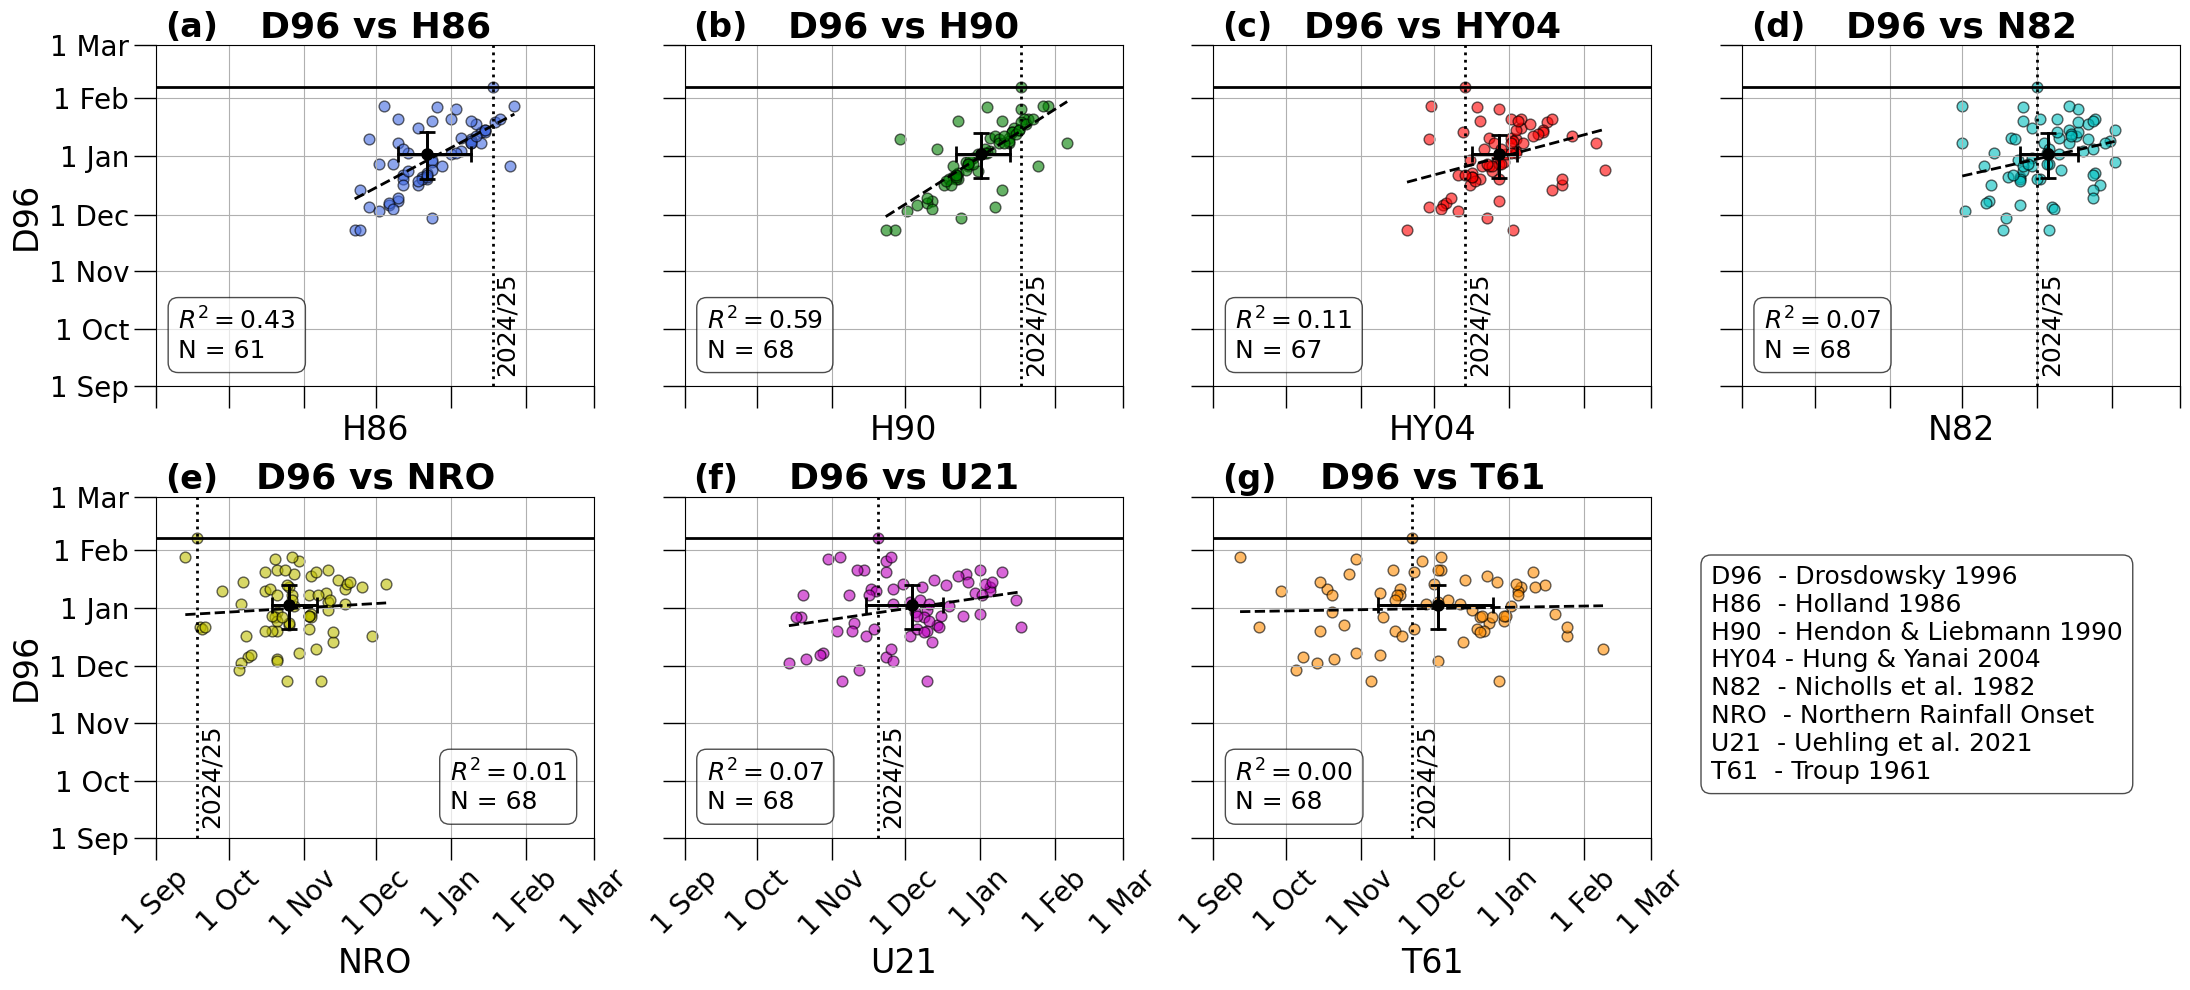

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import numpy as np

# File paths
base_path = "/g/data/dx2/rn0550/Green_Date/Late_Monsoon_Onset_Paper/Monsoon_Definitions_longterm_data/CHECK_ASM_Definitions/"
files = [
    "Drosdowsky_1996_Onset_Dates_using_Lisonbee_Ribbie_weights_weighted_U_wind_1957_2025_NEW2.csv",
    "Holland_1986_Onset_Dates_4.12mps_Nov_start_NEW_check.csv",
    "Hendon_and_Liebmann_1990_Onset_Dates_AGCD_uwnd4.1mps_NEW.csv",  
    "Hung_Yanai_2004_Onset_Dates_1940_2024_using_ERA5_u_ttr_data2.csv",
    "Nicholls_1982_Onset_Dates_1941_2025.csv",
    "NRO_Onset_Dates_station_data.csv",
    "Uehling_2021_Onset_Dates_1941_2025_station_data.csv",
    "Troupe_1961_Onset_Dates_1941_2024_RainfallSpellOnly_at_DARWIN_station_data.csv"
]

legend_names = [
    "D96", 
    "H86", 
    "H90", 
    "HY04", 
    "N82", 
    "NRO",
    "U21", 
    "T61"
]

def onset_to_y(onset_date):
    month_mapping = {9: 0, 10: 30, 11: 61, 12: 91, 1: 122, 2: 153, 3: 181}
    base = month_mapping.get(onset_date.month, 1)
    return base + onset_date.day

# Loading Drosdowsky onset data
df_dros = pd.read_csv(base_path + files[0])
df_dros['Onset Date'] = pd.to_datetime(df_dros['Onset Date'], errors='coerce')
df_dros = df_dros.dropna(subset=['Onset Date'])
df_dros = df_dros[df_dros['Year'] >= 1957]
df_dros['y_value'] = df_dros['Onset Date'].apply(onset_to_y)

#########################################################################################################################
# Plotting
fig, axes = plt.subplots(2, 4, figsize=(22, 10), sharex=True, sharey=True)
plt.subplots_adjust(wspace=0.08)
axes = axes.flatten()
y_labels = ["1 Sep", "1 Oct", "1 Nov", "1 Dec", "1 Jan", "1 Feb", "1 Mar"]
y_positions = [0, 30, 61, 91, 122, 153, 181]
colors = ['royalblue', 'g', 'r', 'c', 'y', 'm', 'darkorange']
subplot_labels = ['(a)', '(b)', '(c)', '(d)', '(e)', '(f)', '(g)']

for i in range(1, 8):
    df_other = pd.read_csv(base_path + files[i])
    df_other['Onset Date'] = pd.to_datetime(df_other['Onset Date'], errors='coerce')
    df_other = df_other.dropna(subset=['Onset Date'])
    df_other = df_other[df_other['Year'] >= 1957]
    df_other['x_value'] = df_other['Onset Date'].apply(onset_to_y)
    df_merged = pd.merge(df_dros[['Year', 'y_value']], df_other[['Year', 'x_value']], on='Year', how='inner')
    
    # Computing IQR for x and y values
    x_Q1, x_Q3 = np.percentile(df_merged['x_value'], [25, 75])
    y_Q1, y_Q3 = np.percentile(df_merged['y_value'], [25, 75])
    
    x_IQR = x_Q3 - x_Q1
    y_IQR = y_Q3 - y_Q1

    x_median = np.median(df_merged['x_value'])
    y_median = np.median(df_merged['y_value'])
    
    axes[i-1].scatter(df_merged['x_value'], df_merged['y_value'], alpha=0.6, edgecolors='k', color=colors[i-1], s=60)

    axes[i-1].plot([x_Q1, x_Q3], [y_median, y_median], color='black', linewidth=2)  # IQR for x
    axes[i-1].plot([x_median, x_median], [y_Q1, y_Q3], color='black', linewidth=2)  # IQR for y


    # Regression line
    m, b = np.polyfit(df_merged['x_value'], df_merged['y_value'], 1)
    x_vals = np.linspace(df_merged['x_value'].min(), df_merged['x_value'].max(), 100)
    y_vals = m * x_vals + b  
    axes[i-1].plot(x_vals, y_vals, color='black', linestyle='--', linewidth=2, label="Regression Line")

    # R² value
    correlation_matrix = np.corrcoef(df_merged['x_value'], df_merged['y_value'])
    r_squared = correlation_matrix[0, 1] ** 2  
    equation_text = f"$R^2 = {r_squared:.2f}$"
 
    # Sample size
    valid_points = df_merged[['x_value', 'y_value']].dropna()
    n_points = len(valid_points)
    combined_text = f"{equation_text}\nN = {n_points}"

    x_pos_combined = 0.05 if i != 5 else 0.67
    y_pos_combined = 0.23  

    axes[i-1].text(
        x_pos_combined, y_pos_combined,
        combined_text,
        transform=axes[i-1].transAxes,
        fontsize=18,
        verticalalignment='top',
        horizontalalignment='left',
        bbox=dict(facecolor='white', edgecolor='black', alpha=0.7, boxstyle='round,pad=0.4')
    )

########################################################################################################################

    axes[i-1].errorbar(
        x=x_median, y=y_median,
        xerr=[[x_median - x_Q1], [x_Q3 - x_median]],
        yerr=[[y_median - y_Q1], [y_Q3 - y_median]],
        fmt='o', color='black', markersize=8, capsize=6, capthick=2, elinewidth=2
    )
    axes[i-1].set_title(f"D96 vs {legend_names[i]}", fontsize=26, fontweight='bold')
    axes[i-1].set_xticks(y_positions)
    axes[i-1].set_xticklabels(y_labels, rotation=45, fontsize=20)
    axes[i-1].set_yticks(y_positions)
    axes[i-1].set_yticklabels(y_labels, fontsize=20)
    axes[i-1].set_xlabel(legend_names[i], fontsize=24)
    
    ncols = 4
    if (i - 1) % ncols == 0:    
        axes[i-1].set_ylabel("D96", fontsize=24)
        
    axes[i-1].axhline(y=159, color='black', linestyle='-', linewidth=2)
    axes[i-1].grid()
    axes[i-1].tick_params(axis='both', which='major', length=16, width=1)  

    df_2024 = df_merged[df_merged['Year'] == 2024]
    if not df_2024.empty:
        x_2024 = df_2024['x_value'].values[0]
        y_2024 = df_2024['y_value'].values[0]

    axes[i-1].axvline(x=x_2024, color='k', linestyle=':', linewidth=2)

    axes[i-1].text(
        x_2024 + 1, 
        axes[i-1].get_ylim()[0] + 5,
        "2024/25",
        rotation=90,
        color='k',
        fontsize=18,
        verticalalignment='bottom'
    )
    
    axes[i-1].text(
        0.02, 1.1, subplot_labels[i-1], 
        transform=axes[i-1].transAxes, 
        fontsize=24, fontweight='bold',
        va='top', ha='left'
    )

fig.delaxes(axes[-1])

legend_text = (
    "D96  - Drosdowsky 1996\n"
    "H86  - Holland 1986\n"
    "H90  - Hendon & Liebmann 1990\n"
    "HY04 - Hung & Yanai 2004\n"
    "N82  - Nicholls et al. 1982\n"
    "NRO  - Northern Rainfall Onset\n"
    "U21  - Uehling et al. 2021\n"
    "T61  - Troup 1961"
)

fig.text(
    0.78, 0.43,  
    legend_text,
    fontsize=18,
    verticalalignment='top',
    horizontalalignment='left',
    bbox=dict(facecolor='white', edgecolor='black', alpha=0.7, boxstyle='round,pad=0.4')
)


plt.tight_layout()

#plt.savefig("/g/data/dx2/rn0550/Green_Date/Late_Monsoon_Onset_Paper/FIGURES/Scatter_Drosdowsky_vs_Others_corrected.png", dpi=1000, bbox_inches='tight')
plt.show()




<span style="color:darkorange; font-size:35px;"><b>Suppl. Fig. 4</b></span>

## Weipa D96

Monsoon onset date for 2024-2025: 2025-01-30


/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/pandas/core/indexes/base.py:7588: FutureWarning: Dtype inference on a pandas object (Series, Index, ExtensionArray) is deprecated. The Index constructor will keep the original dtype in the future. Call `infer_objects` on the result to get the old behavior.
  return Index(sequences[0], name=names)


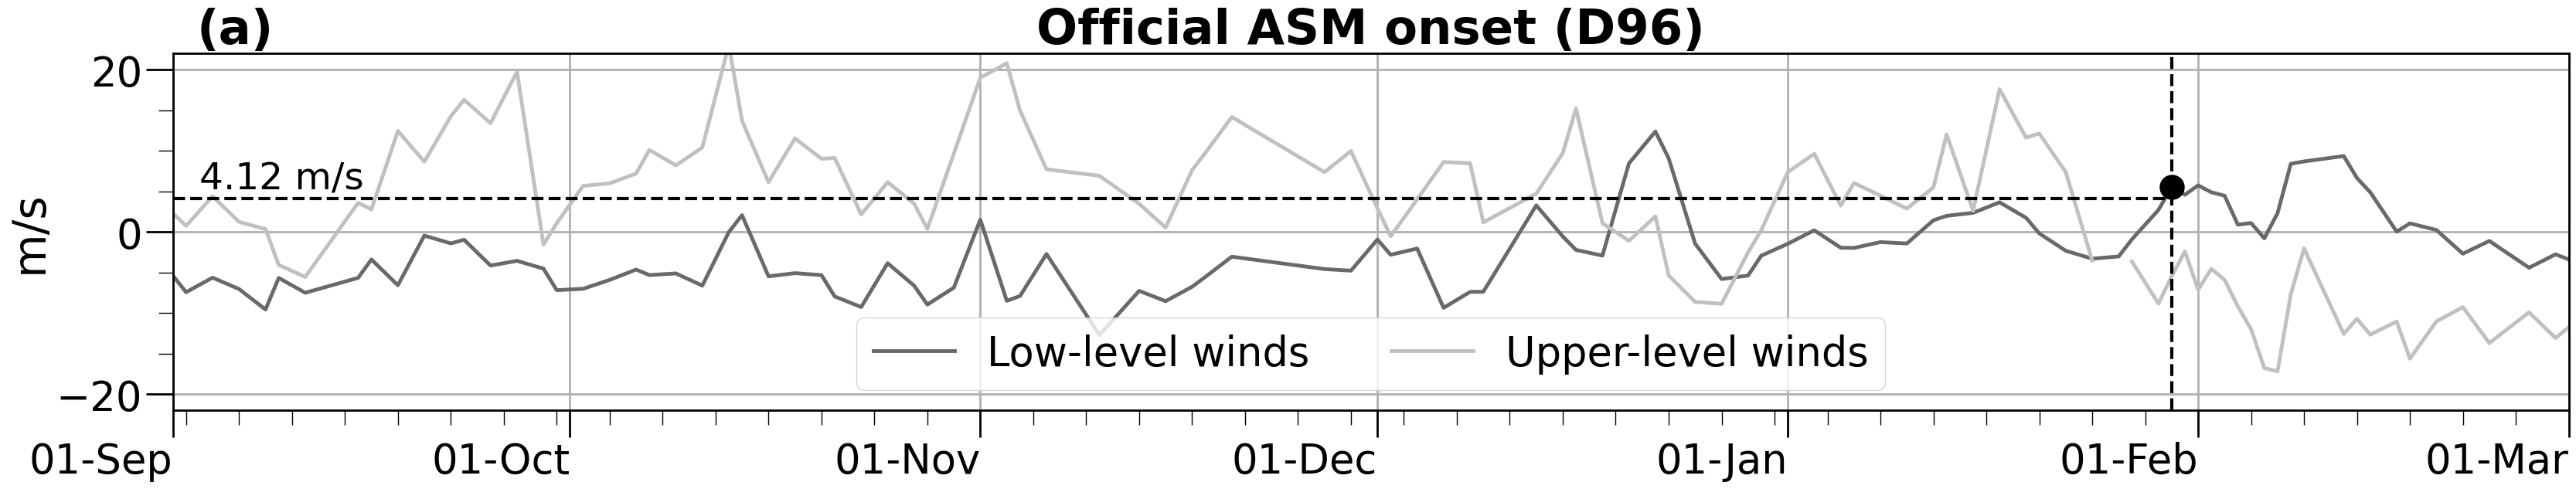

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.dates as mdates

year = 2024
threshold = 4.12

# Loading weighted uwind data
file_path = "/g/data/dx2/rn0550/Green_Date/Late_Monsoon_Onset_Paper/Radiosonde_WEIPA/NEW_using_Lisonbee_Ribbie_weights_weighted_U_wind_1993_2025.csv"
df = pd.read_csv(file_path, parse_dates=['Date'], dayfirst=True)
df['Hour'] = pd.to_numeric(df['Hour'], errors='coerce')
df = df[df['Hour'] == 0]
start_date, end_date = f"{year}-09-01", f"{year+1}-04-30"
df_period = df[(df['Date'] >= start_date) & (df['Date'] <= end_date)]

def find_monsoon_onset(df):
    onset_date = None

    for i in range(1, len(df)):  
        if (
            df['U_weighted_mean_low'].iloc[i] > threshold and  
            df['U_weighted_mean_low'].iloc[i-1] > threshold and
            df['U_weighted_mean_upper'].iloc[i] < 0 and  
            df['U_weighted_mean_upper'].iloc[i-1] < 0
        ):
            onset_date = df['Date'].iloc[i-1]
            break  

    return onset_date, df

onset_24_25, df_24_25 = find_monsoon_onset(df_period)

print(f"Monsoon onset date for {year}-{year+1}: {onset_24_25}")

################################################################################################################
# Plotting
fig, axs = plt.subplots(figsize=(40, 6), sharex=True)

df_24_25.loc[:, 'Date'] = pd.to_datetime(df_24_25['Date'])
df_24_25 = df_24_25.set_index('Date')

axs.plot(df_24_25.index, df_24_25['U_weighted_mean_low'], label="Low-level winds", color="dimgrey", linewidth=3.5)
axs.plot(df_24_25.index, df_24_25['U_weighted_mean_upper'], label="Upper-level winds", color="silver", linewidth=3.5)
axs.set_ylabel("m/s", fontsize=42)
axs.set_title("Official ASM onset (D96)", fontsize=45, fontweight='bold')
axs.legend(fontsize=38, ncols = 2, loc = 'lower center')
axs.grid()
axs.set_xlim(df_24_25.index[0], df_24_25.index[-1])
axs.set_xlim(pd.to_datetime("2024-09-01"), pd.to_datetime("2025-03-01"))
axs.tick_params(axis='y', size=38)
axs.tick_params(axis='both', labelsize=38)
axs.set_ylim(-22, 22)
axs.xaxis.set_major_formatter(mdates.DateFormatter('%d-%b'))
plt.setp(axs.xaxis.get_majorticklabels(), rotation=360, ha="right")
tick_dates = pd.date_range(start="2024-09-01", end="2025-03-01", freq='MS')
axs.set_xticks(tick_dates)

if onset_24_25:
    onset_24_25 = pd.to_datetime(onset_24_25)
    axs.axvline(onset_24_25, color='black', linestyle='--', linewidth=3)
    onset_y = df_24_25.at[onset_24_25, 'U_weighted_mean_low']
    axs.scatter(onset_24_25, onset_y, color='k', edgecolors="black", marker='o', s=500, zorder=3)

plt.tick_params(axis='both', labelsize=38) 

axs.text(df_24_25.index.min() + pd.Timedelta(days=2), threshold + 0.2, f"{threshold} m/s", 
        color="black", fontsize=35, verticalalignment="bottom", horizontalalignment="left")  

plt.minorticks_on()

plt.tick_params(axis='both', which='major', length=25, width=2)  
plt.tick_params(axis='both', which='minor', length=14, width=1) 

axs.xaxis.set_minor_locator(ticker.MultipleLocator(4)) 

for spine in axs.spines.values():
    spine.set_linewidth(2)  

axs.grid(True, linewidth=2)

if onset_24_25 is not None:
    axs.hlines(y=threshold, xmin=df_24_25.index.min(), xmax=onset_24_25, 
               color='k', linestyle='--', linewidth=3)
else:
    axs.axhline(threshold, color='black', linestyle='--', linewidth=3)

axs.text(0.01, 1.13, "(a)", transform=axs.transAxes, fontsize=45, fontweight='bold', va='top', ha='left')

plt.show()

#fig.savefig("/g/data/dx2/rn0550/Green_Date/Late_Monsoon_Onset_Paper/Radiosonde_WEIPA/Weipa_monsoon_onset_figs/onsets_fig/1_Drosdowsky_1996_2024-2025.png", dpi=600, bbox_inches='tight')



## Weipa H86

/jobfs/142929535.gadi-pbs/ipykernel_1231191/3996200049.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['Two_Day_Period'] = pd.cut(df_filtered['Date'], bins=bins, right=False)
/jobfs/142929535.gadi-pbs/ipykernel_1231191/3996200049.py:19: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_2day = df_filtered.groupby('Two_Day_Period', as_index=False)['U'].mean()


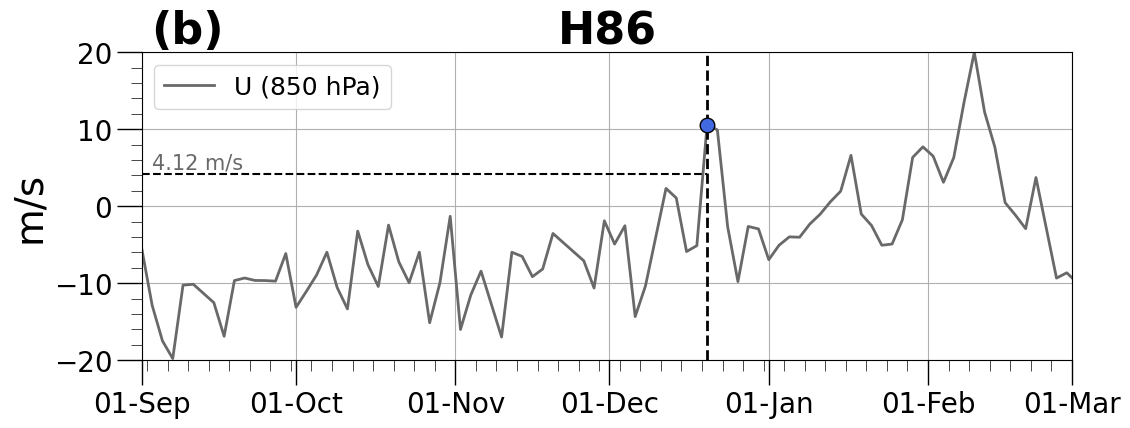

The H86 monsoon onset date is: 2024-12-20 00:00:00


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import UnivariateSpline
import matplotlib.ticker as ticker

threshold = 4.12

# Loading the 850hPa uwind 
df = pd.read_csv("/g/data/dx2/rn0550/Green_Date/Late_Monsoon_Onset_Paper/Radiosonde_WEIPA/Weipa_Radio_Sonde_data_WITH_UV_with_NaNs_850hPa_filtered.csv")

df['Date'] = pd.to_datetime(df['Date'], format='mixed', dayfirst=True)
mask = (df['Date'] >= "2024-09-01") & (df['Date'] <= "2025-04-30")
df_filtered = df[mask]
bins = pd.date_range(start=df_filtered['Date'].min(), 
                     end=df_filtered['Date'].max(), 
                     freq='2D')
df_filtered['Two_Day_Period'] = pd.cut(df_filtered['Date'], bins=bins, right=False)
df_2day = df_filtered.groupby('Two_Day_Period', as_index=False)['U'].mean()
df_2day['Two_Day_Period'] = df_2day['Two_Day_Period'].apply(lambda x: x.left)
df_2day = df_2day.dropna()
x_2day = np.arange(len(df_2day))
y_2day = df_2day['U'].values

spline = UnivariateSpline(x_2day, y_2day, s=0)
y_smooth = spline(x_2day)

monsoon_onset_index = np.where(y_smooth >= threshold)[0]
if monsoon_onset_index.size > 0:
    monsoon_onset_date = df_2day.iloc[monsoon_onset_index[0]]['Two_Day_Period']
else:
    monsoon_onset_date = None  
    
#######################################################################################################################
# Plotting
fig, ax = plt.subplots(figsize=(12, 4))

plt.plot(df_2day['Two_Day_Period'], y_smooth, label='U (850 hPa)', color='dimgrey', linewidth=2)

if pd.notna(monsoon_onset_date):
    plt.axvline(monsoon_onset_date, color='k', linestyle='--', linewidth=2)
    plt.scatter(monsoon_onset_date, y_smooth[monsoon_onset_index[0]], color='royalblue', edgecolors="black", marker='o', s=110, zorder=3)  
    #plt.text(monsoon_onset_date + pd.Timedelta(days=12), 5, 
             #monsoon_onset_date.strftime('%d-%b-%Y'), 
             #color='k', fontsize=12, fontweight='bold',  verticalalignment='bottom', horizontalalignment='right')


ax.text(df_2day['Two_Day_Period'].min() + pd.Timedelta(days=2), threshold + 0.2, f"{threshold} m/s", 
        color="dimgrey", fontsize=15, verticalalignment="bottom", horizontalalignment="left")  


if monsoon_onset_date is not None:
    plt.hlines(y=threshold, xmin=df_2day['Two_Day_Period'].min(), xmax=monsoon_onset_date, 
               color='k', linestyle='--', linewidth=1.5)
else:
    plt.axhline(threshold, color='k', linestyle='--', linewidth=1.5) 


plt.ylabel("m/s", fontsize=28)
plt.title("H86", fontsize=32, fontweight='bold')
plt.xticks(rotation=45)
plt.legend(fontsize=18, loc='upper left')
plt.tick_params(axis='both', labelsize=20) 
plt.grid(True)

xticks = pd.date_range(start="2024-09-01", end="2025-03-01", freq='1MS')
plt.xticks(xticks, [date.strftime('%d-%b') for date in xticks], rotation=360, fontsize=20)
plt.minorticks_on()
plt.tick_params(axis='both', which='major', length=18, width=1) 
plt.tick_params(axis='both', which='minor', length=8, width=0.5) 
ax.xaxis.set_minor_locator(ticker.MultipleLocator(4)) 
ax.set_xlim(xticks[0], xticks[-1])
ax.set_ylim(-20, 20)
ax.text(0.01, 1.14, "(b)", transform=ax.transAxes, fontsize=32, fontweight='bold', va='top', ha='left')

plt.show()

print("The H86 monsoon onset date is:", monsoon_onset_date)

#fig.savefig("/g/data/dx2/rn0550/Green_Date/Late_Monsoon_Onset_Paper/Radiosonde_WEIPA/Weipa_monsoon_onset_figs/onsets_fig/2_Holland_1986_2024-2025.png", dpi=600, bbox_inches='tight')




## Weipa HL90

/jobfs/142929535.gadi-pbs/ipykernel_1231191/1195944055.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_wind_year['U_smooth'] = np.convolve(df_wind_year['U'], weights, mode='same')


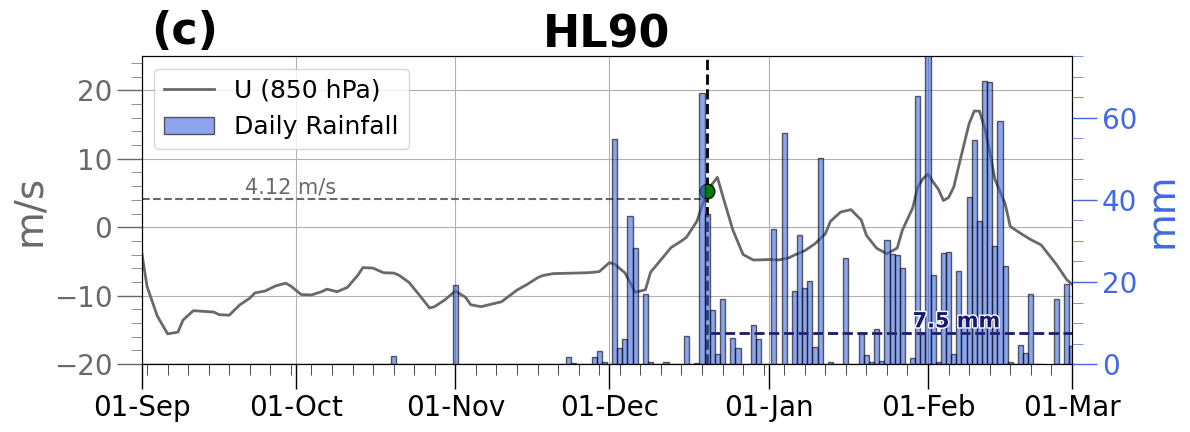

The HL90 monsoon onset date is: 2024-12-20 00:00:00


In [5]:
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.ticker as ticker
import matplotlib.patheffects as path_effects

year = 2024
threshold = 4.12

# Loading the 850hPa uwind 
df_wind = pd.read_csv("/g/data/dx2/rn0550/Green_Date/Late_Monsoon_Onset_Paper/Radiosonde_WEIPA/Weipa_Radio_Sonde_data_WITH_UV_with_NaNs_850hPa_filtered.csv")
df_wind['Date'] = pd.to_datetime(df_wind['Date'], format='mixed', dayfirst=True)
df_wind['Monsoon_Year'] = df_wind['Date'].apply(lambda x: x.year if x.month >= 9 else x.year - 1)
df_wind = df_wind[(df_wind['Date'].dt.month >= 9) | (df_wind['Date'].dt.month <= 4)]

year = 2024

df_wind_year = df_wind[df_wind['Monsoon_Year'] == year]

# 1-2-3-2-1 weighted moving average filter
weights = np.array([1, 2, 3, 2, 1])
weights = weights / weights.sum()  
df_wind_year['U_smooth'] = np.convolve(df_wind_year['U'], weights, mode='same')

########################################################################################################################
# Loading Weipa Aero station rainfall data
excel_file_path = "/g/data/dx2/rn0550/Green_Date/Late_Monsoon_Onset_Paper/Radiosonde_WEIPA/Weipa_Aero_station_rainfall_Jan2024_Mar2025.xlsx"
df_rain = pd.read_excel(excel_file_path, sheet_name='Sheet1', engine='openpyxl')  
df_rain.columns = df_rain.columns.str.strip()
date_col = "Day Month Year in DD/MM/YYYY format"
rain_col = "Precipitation in the 24 hours before 9am (local time) in mm"
df_rain["Date"] = pd.to_datetime(df_rain[date_col], dayfirst=True, errors="coerce")
df_rain[rain_col] = pd.to_numeric(df_rain[rain_col], errors="coerce")
df_rain.rename(columns={rain_col: "Rainfall (mm/day)"}, inplace=True)
df_combined = pd.merge(df_wind_year[["Date", "U_smooth"]], df_rain, on="Date", how="inner")
df_combined.rename(columns={"U_smooth": "Wind_Speed (U)"}, inplace=True)

########################################################################################################################
onset_condition = (df_combined["Wind_Speed (U)"] > threshold) & (df_combined["Rainfall (mm/day)"] > 7.5)
onset_date = df_combined.loc[onset_condition, "Date"]

# Plotting
fig, ax = plt.subplots(figsize=(12, 4))

ax.plot(df_wind_year['Date'], df_wind_year['U_smooth'], label="U (850 hPa)", color="dimgrey", linewidth=2)
ax.set_ylabel("m/s", color="dimgrey", fontsize=28)
ax.tick_params(axis='y', labelcolor="dimgrey", labelsize=20)
ax.grid()
ax.text(df_wind_year['Date'].min() + pd.Timedelta(days=20), threshold + 0.2, f"{threshold} m/s", 
        color="dimgrey", fontsize=15, verticalalignment="bottom", horizontalalignment="left") 

ax.set_xlim(df_wind_year['Date'].min(), df_wind_year['Date'].max())
ax.set_ylim(-20, 25)

rain_col = "Rainfall (mm/day)"

ax2 = ax.twinx()
if df_rain is not None:
    ax2.bar(df_rain["Date"], df_rain[rain_col], width=1, color='royalblue', edgecolor='black', alpha=0.6, label='Daily Rainfall', zorder=1)

ax2.set_ylabel("mm", color="royalblue", fontsize=28)
ax2.tick_params(axis='y', labelcolor="royalblue", labelsize=20)

ax2.text(
    df_wind_year['Date'].min() + pd.Timedelta(days=150), 
    7.5 + 0.5, 
    "7.5 mm", 
    color="#191970", 
    fontsize=15, fontweight = 'bold',
    verticalalignment="bottom", 
    horizontalalignment="left",
    path_effects=[path_effects.withStroke(linewidth=2, foreground='white')]
)

ax2.set_ylim(0, 75)
ax2.tick_params(axis='both', labelsize=15)
ax.tick_params(axis='y', labelsize=20, color="dimgrey") 
ax.tick_params(axis='y', which='minor', length=8, width=0.5, color="dimgrey") 
ax.set_title("HL90", fontsize=32, fontweight="bold")
xticks = pd.date_range(start="2024-09-01", end="2025-03-01", freq='1MS')
ax.set_xticks(xticks, [date.strftime('%d-%b') for date in xticks], rotation=360, fontsize=20)
ax.minorticks_on()
ax.tick_params(axis='both', which='major', length=18, width=1) 
ax.tick_params(axis='both', which='minor', length=8, width=0.5) 
ax.xaxis.set_minor_locator(ticker.MultipleLocator(4)) 
ax.set_xlim(xticks[0], xticks[-1])
ax2.minorticks_on()
ax2.tick_params(axis='both', which='major', length=18, width=1, color="royalblue")  
ax2.tick_params(axis='both', which='minor', length=8, width=0.5, color="royalblue") 
ax2.xaxis.set_minor_locator(ticker.MultipleLocator(4)) 
ax2.set_xlim(xticks[0], xticks[-1])
ax2.tick_params(axis='y', labelsize=20)

lines1, labels1 = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax.legend(lines1 + lines2, labels1 + labels2, loc="upper left", fontsize=18)

if not onset_date.empty:
    onset_date = onset_date.iloc[0]
    ax.axvline(onset_date, color='black', linestyle='--', label="Monsoon Onset", linewidth=2)
    onset_wind_speed = df_wind_year.loc[df_wind_year['Date'] == onset_date, 'U_smooth'].values
    ax.scatter(onset_date, onset_wind_speed[0], color='g', edgecolors="black", marker='o', s=110, zorder=3) 
    #ax.text(onset_date + pd.Timedelta(days=8), 20, f"{onset_date.date().strftime('%d-%b-%Y')}", 
    #        verticalalignment='bottom', horizontalalignment='right', fontsize=12, color='black', fontweight='bold')


if onset_date is not None:
    ax.hlines(y=threshold, xmin=df_wind_year['Date'].min(), xmax=onset_date, 
               color='dimgrey', linestyle='--', linewidth=1.5)
    ax2.hlines(y=7.5, xmin=df_wind_year['Date'].max(), xmax=onset_date, 
               color='#191970', linestyle='--', linewidth=2, path_effects=[path_effects.withStroke(linewidth=2, foreground='white')])
    
else:
    ax.axhline(threshold, color='dimgrey', linestyle='--', linewidth=1.5)  
    ax2.axhline(7.5, color='blue', linestyle='--', linewidth=1.5) 

ax.text(0.01, 1.15, "(c)", transform=ax.transAxes, fontsize=32, fontweight='bold', va='top', ha='left')

plt.show()

#fig.savefig("/g/data/dx2/rn0550/Green_Date/Late_Monsoon_Onset_Paper/Radiosonde_WEIPA/Weipa_monsoon_onset_figs/onsets_fig/3_Hendon_Liebmann_1990_2024-2025.png", dpi=600, bbox_inches='tight')

#######################################################################################################################

print("The HL90 monsoon onset date is:", onset_date)



## Weipa D96 vs H86/HL90 scatter plots

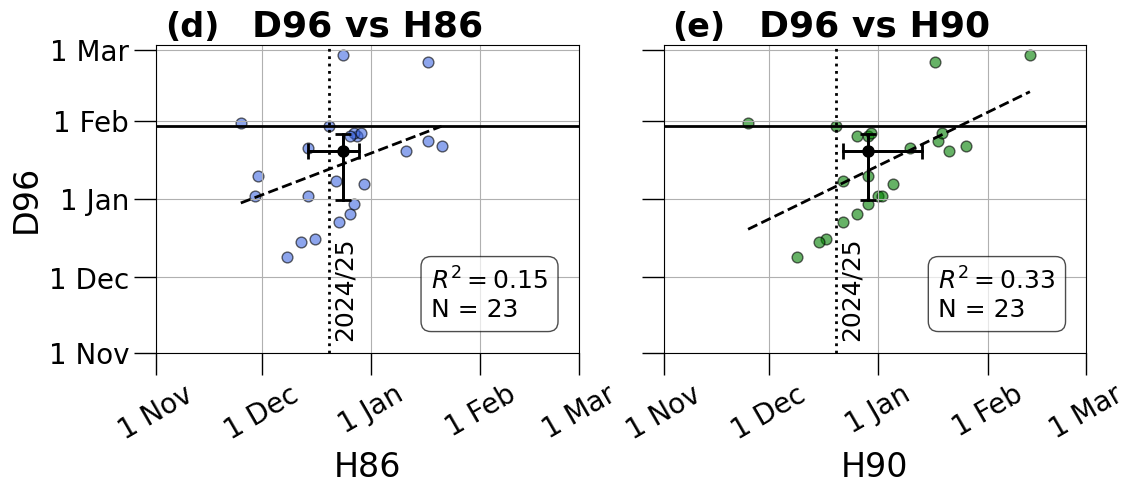

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import numpy as np

# File paths
base_path = "/g/data/dx2/rn0550/Green_Date/Late_Monsoon_Onset_Paper/Radiosonde_WEIPA/ASM_definitions/"
files = [
    "Latest_00z_Drosdowsky_1996_Onset_Dates_using_Lisonbee_Ribbie_weights_weighted_U_wind_1993_2025_4.12mps.csv",
    "Weipa_Holland_1986_Onset_Dates_4.12mps_Nov_start.csv",
    "Weipa_HL_1990_Onset_Dates.csv"
]

legend_names = [
    "D96", 
    "H86", 
    "H90"
]

def onset_to_y(onset_date):
    month_mapping = {9: 0, 10: 30, 11: 61, 12: 91, 1: 122, 2: 153, 3: 181}
    base = month_mapping.get(onset_date.month, 1)
    return base + onset_date.day - 1

df_dros = pd.read_csv(base_path + files[0])
df_dros['Onset Date'] = pd.to_datetime(df_dros['Onset Date'], errors='coerce')
df_dros = df_dros.dropna(subset=['Onset Date'])
df_dros = df_dros[df_dros['Year'] >= 1957]
df_dros['y_value'] = df_dros['Onset Date'].apply(onset_to_y)

###################################################################################################################
# Plotting
fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharex=True, sharey=True)

y_labels = ["1 Nov", "1 Dec", "1 Jan", "1 Feb", "1 Mar"]
y_positions = [61, 91, 122, 153, 181]

colors = ['royalblue', 'g', 'r']

panel_labels = ['(d)', '(e)']

for i in range(1, 3):
    df_other = pd.read_csv(base_path + files[i])
    df_other['Onset Date'] = pd.to_datetime(df_other['Onset Date'], errors='coerce')
    df_other = df_other.dropna(subset=['Onset Date'])
    df_other = df_other[df_other['Year'] >= 1957]
    df_other['x_value'] = df_other['Onset Date'].apply(onset_to_y)
    df_merged = pd.merge(df_dros[['Year', 'y_value']], df_other[['Year', 'x_value']], on='Year', how='inner')
    
    # Computing IQR for x and y values
    x_Q1, x_Q3 = np.percentile(df_merged['x_value'], [25, 75])
    y_Q1, y_Q3 = np.percentile(df_merged['y_value'], [25, 75])
    
    x_IQR = x_Q3 - x_Q1
    y_IQR = y_Q3 - y_Q1

    x_median = np.median(df_merged['x_value'])
    y_median = np.median(df_merged['y_value'])
    
    axes[i-1].scatter(df_merged['x_value'], df_merged['y_value'], alpha=0.6, edgecolors='k', color=colors[i-1], s=60)
    axes[i-1].plot([x_Q1, x_Q3], [y_median, y_median], color='black', linewidth=2)  # IQR for x
    axes[i-1].plot([x_median, x_median], [y_Q1, y_Q3], color='black', linewidth=2)  # IQR for y

    # Regression line
    m, b = np.polyfit(df_merged['x_value'], df_merged['y_value'], 1)
    x_vals = np.linspace(df_merged['x_value'].min(), df_merged['x_value'].max(), 100)
    y_vals = m * x_vals + b  
    axes[i-1].plot(x_vals, y_vals, color='black', linestyle='--', linewidth=2, label="Regression Line")

    # R² value
    correlation_matrix = np.corrcoef(df_merged['x_value'], df_merged['y_value'])
    r_squared = correlation_matrix[0, 1] ** 2  
    equation_text = f"$R^2 = {r_squared:.2f}$"
 
    # Sample size
    valid_points = df_merged[['x_value', 'y_value']].dropna()
    n_points = len(valid_points)

    combined_text = f"{equation_text}\nN = {n_points}"

    x_pos_combined = 0.65 if i != 5 else 0.67
    y_pos_combined = 0.28  

    axes[i-1].text(
        x_pos_combined, y_pos_combined,
        combined_text,
        transform=axes[i-1].transAxes,
        fontsize=18,
        verticalalignment='top',
        horizontalalignment='left',
        bbox=dict(facecolor='white', edgecolor='black', alpha=0.7, boxstyle='round,pad=0.4')
    )

########################################################################################################################

    axes[i-1].errorbar(
        x=x_median, y=y_median,
        xerr=[[x_median - x_Q1], [x_Q3 - x_median]],
        yerr=[[y_median - y_Q1], [y_Q3 - y_median]],
        fmt='o', color='black', markersize=8, capsize=6, capthick=2, elinewidth=2
    )

    axes[i-1].set_title(f"D96 vs {legend_names[i]}", fontsize=26, fontweight='bold')
    axes[i-1].set_xticks(y_positions)
    axes[i-1].set_xticklabels(y_labels, rotation=30, fontsize=20)
    axes[i-1].set_yticks(y_positions)
    axes[i-1].set_yticklabels(y_labels, fontsize=20)
    axes[i-1].set_xlabel(legend_names[i], fontsize=24)
    if i == 1:
        axes[i-1].set_ylabel("D96", fontsize=24)

    axes[i-1].axhline(y=151, color='black', linestyle='-', linewidth=2)
    axes[i-1].grid()
    axes[i-1].tick_params(axis='both', which='major', length=16, width=1)

    df_2024 = df_merged[df_merged['Year'] == 2024]
    if not df_2024.empty:
        x_2024 = df_2024['x_value'].values[0]
        y_2024 = df_2024['y_value'].values[0]

    axes[i-1].axvline(x=x_2024, color='k', linestyle=':', linewidth=2)

    axes[i-1].text(
        x_2024 + 1, 
        axes[i-1].get_ylim()[0] + 5,
        "2024/25",
        rotation=90,
        color='k',
        fontsize=18,
        verticalalignment='bottom'
    )
    
    axes[i-1].text(
        0.02, 1.11, panel_labels[i-1], 
        transform=axes[i-1].transAxes, 
        fontsize=24, fontweight='bold',
        va='top', ha='left'
    )

#plt.savefig("/g/data/dx2/rn0550/Green_Date/Late_Monsoon_Onset_Paper/Radiosonde_WEIPA/Weipa_monsoon_onset_figs/Scatter_Drosdowsky_vs_H86_HL90_WEIPA.png", dpi=600, bbox_inches='tight')

plt.show()



<span style="color:darkorange; font-size:35px;"><b>Suppl. Fig. 6</b></span>

Missing RMM data for onset date: 1957-12-30 00:00:00
Missing RMM data for onset date: 1959-01-10 00:00:00
Missing RMM data for onset date: 1960-01-19 00:00:00
Missing RMM data for onset date: 1960-12-28 00:00:00
Missing RMM data for onset date: 1962-01-11 00:00:00
Missing RMM data for onset date: 1963-01-25 00:00:00
Missing RMM data for onset date: 1964-01-03 00:00:00
Missing RMM data for onset date: 1965-01-27 00:00:00
Missing RMM data for onset date: 1966-01-15 00:00:00
Missing RMM data for onset date: 1967-01-20 00:00:00
Missing RMM data for onset date: 1968-01-20 00:00:00
Missing RMM data for onset date: 1969-01-09 00:00:00
Missing RMM data for onset date: 1969-12-22 00:00:00
Missing RMM data for onset date: 1970-12-05 00:00:00
Missing RMM data for onset date: 1971-12-07 00:00:00
Missing RMM data for onset date: 1973-01-27 00:00:00
Missing RMM data for onset date: 1973-11-22 00:00:00


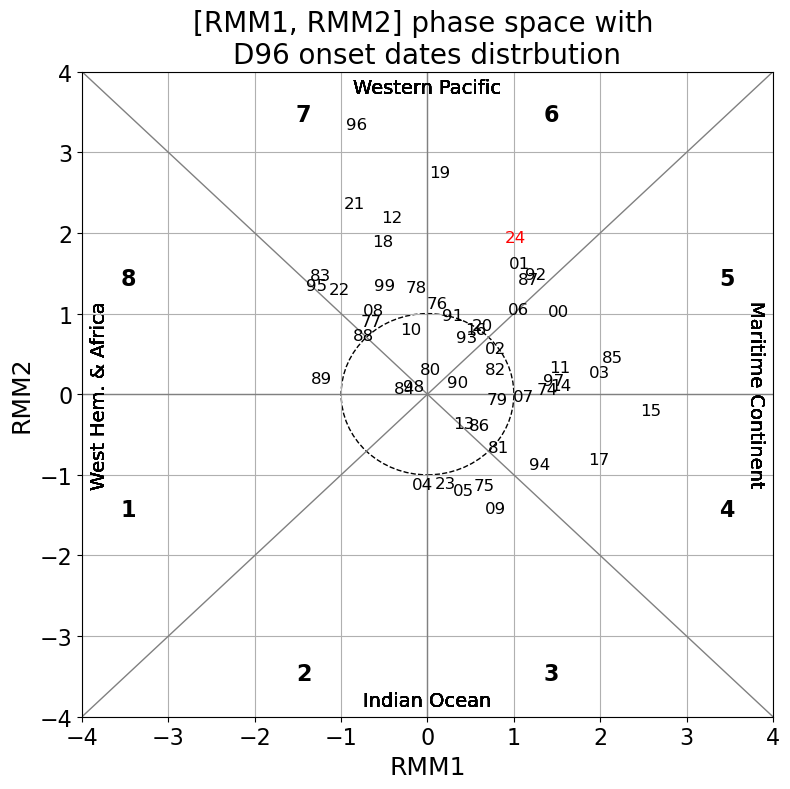

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# --- Loading RMM data ---
file_path_rmm = "/g/data/dx2/rn0550/Green_Date/Late_Monsoon_Onset_Paper/rmm.74toRealtime.txt"
df_rmm = pd.read_csv(file_path_rmm, sep="\s+", skiprows=2, header=None, usecols=range(7))
df_rmm.columns = ["year", "month", "day", "RMM1", "RMM2", "phase", "amplitude"]
df_rmm["time"] = pd.to_datetime(df_rmm[["year", "month", "day"]])
df_rmm = df_rmm.set_index("time")[["RMM1", "RMM2"]]
rmm_monthly = df_rmm.resample("1ME").mean()
rmm_monthly["Year"] = rmm_monthly.index.year
rmm_annual = rmm_monthly.groupby("Year").mean()

# --- Loading D96 onset dates ---
onset_dates_df = pd.read_csv(
    "/g/data/dx2/rn0550/Green_Date/Late_Monsoon_Onset_Paper/Monsoon_Definitions_longterm_data/CHECK_ASM_Definitions/Drosdowsky_1996_Onset_Dates_using_Lisonbee_Ribbie_weights_weighted_U_wind_1957_2025_NEW2.csv")

onset_dates_df['Onset Date'] = pd.to_datetime(onset_dates_df['Onset Date'])
onset_dates_df['Onset Day'] = (
    onset_dates_df['Onset Date'] - pd.to_datetime(onset_dates_df['Year'].astype(str) + "-09-01")
).dt.days
onset_df = onset_dates_df.set_index('Year')[['Onset Day']]
onset_df_clean = onset_df.dropna(subset=["Onset Day"])

#######################################################################################################################################
onset_rmm = []
for year, row in onset_df.iterrows():
    onset_day = row['Onset Day']
    
    if pd.isna(onset_day):
        continue  
    
    onset_date = pd.Timestamp(f"{year}-09-01") + pd.Timedelta(days=int(onset_day))

    if onset_date in df_rmm.index:
        rmm_values = df_rmm.loc[onset_date]
        onset_rmm.append((year, onset_date.strftime("%Y-%m-%d"), rmm_values["RMM1"], rmm_values["RMM2"]))
    else:
        print(f"Missing RMM data for onset date: {onset_date}")


onset_rmm_df = pd.DataFrame(onset_rmm, columns=["Year", "Onset Date", "RMM1", "RMM2"])

#######################################################################################################################################
# Plotting
phase_regions = {
    (1, 8): "West Hem. & Africa",
    (2, 3): "Western Pacific",
    (4, 5): "Maritime Continent",
    (6, 7):  "Indian Ocean"    
}

fig, ax = plt.subplots(figsize=(8, 8))

circle = plt.Circle((0, 0), 1, color='black', fill=False, linestyle='--')
ax.add_artist(circle)

limit = 4
ax.set_xlim(-limit, limit)
ax.set_ylim(-limit, limit)

line_length = 6  
for phase in range(8):
    angle = np.deg2rad(45 * phase)
    x = np.cos(angle)
    y = np.sin(angle)
    ax.plot([0, line_length * x], [0, line_length * y], color='gray', linewidth=1)

for phase in range(8):
    phase_number = (phase + 4) % 8 + 1  
    angle = np.deg2rad(45 * phase + 22.5)  
    x = np.cos(angle)
    y = np.sin(angle)

    ax.text(3.75 * x, 3.75 * y, str(phase_number), ha='center', va='center', fontsize=16, fontweight='bold')

    for phases, region in phase_regions.items():
        start_angle = np.deg2rad(45 * (phases[0] - 1) + 22.5)
        end_angle = np.deg2rad(45 * (phases[1] - 1) + 22.5)
        angle_mid = (start_angle + end_angle) / 2

        radius = 3.8 
        if phases == (1, 8):  
            radius = 3.8  
        elif phases == (4, 5):  
            radius = -3.8  

        x = radius * np.cos(angle_mid)
        y = radius * np.sin(angle_mid)

        if phases == (1, 8):
            rotation = 90
        elif phases == (4, 5):
            rotation = -90 if x >= 0 else 270
        else:
            rotation = 0

        ax.text(x, y, region, ha='center', va='center', fontsize=14, color='black', rotation=rotation)

ax.set_xlabel("RMM1", fontsize=18)
ax.set_ylabel("RMM2", fontsize=18)
ax.set_title("[RMM1, RMM2] phase space with \nD96 onset dates distrbution", fontsize=20)
ax.grid(True)
ax.tick_params(axis='both', labelsize=16)

for _, row in onset_rmm_df.iterrows():
    year_short = str(row["Year"])[-2:]
    color = 'red' if row["Year"] == 2024 else 'black'
    ax.text(row["RMM1"], row["RMM2"], year_short, fontsize=12, ha='center', va='center', color=color)


plt.tight_layout()

#plt.savefig("/g/data/dx2/rn0550/Green_Date/Late_Monsoon_Onset_Paper/FIGURES/MJO_D96_dates_distribution.png", dpi=600, bbox_inches='tight', format='png')

plt.show()


<span style="color:darkorange; font-size:35px;"><b>Suppl. Fig. 7</b></span>

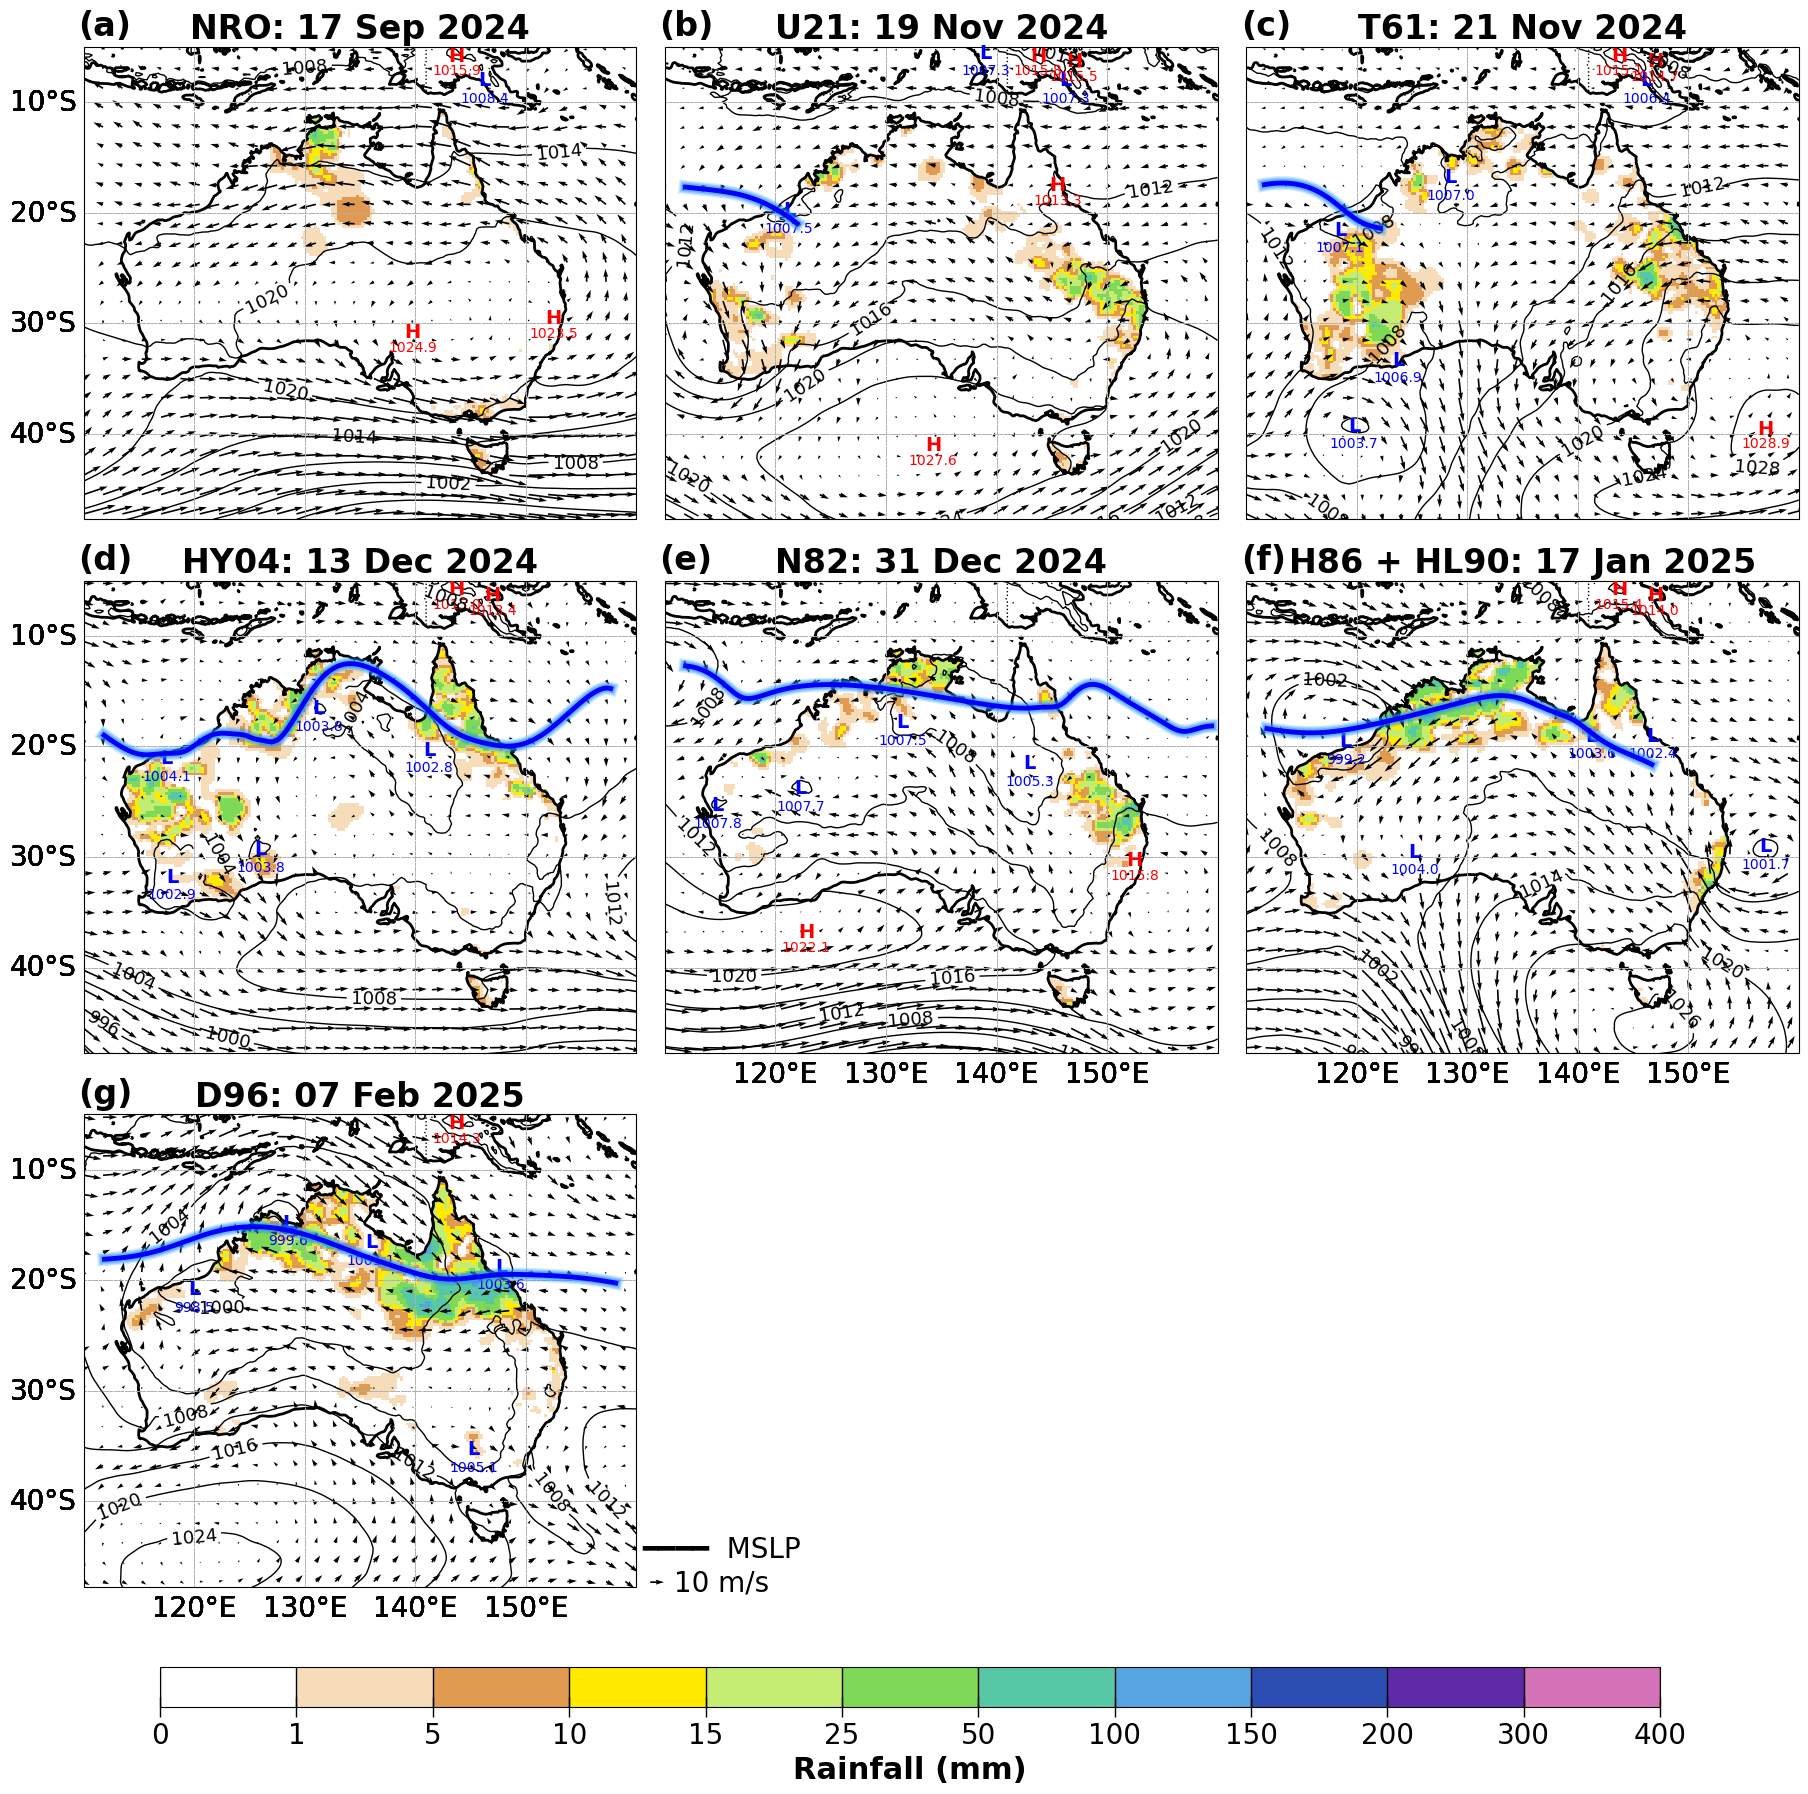

In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np
import os
from metpy.calc import divergence, lat_lon_grid_deltas
from metpy.units import units
from metpy.calc import vorticity
import glob
from matplotlib import colors
from datetime import datetime
import geopandas as gpd
from scipy.ndimage import minimum_filter, maximum_filter, label, find_objects
from scipy.ndimage import gaussian_filter1d
import datetime
import pandas as pd
import datetime as dt
import matplotlib.image as mpimg
import matplotlib.colors as colors
import matplotlib.cm as cm
import string

lat_extent = slice(0, -50)
lon_extent = slice(110, 160)

start_date = '2024-09-01'
end_date = '2025-02-20'

# Loading SLP data
slp_2024 = xr.open_dataset('/g/data/dx2/rn0550/Green_Date/ERA5/ERA5_MSLP/MSLP_2024.nc')
slp_2024 = slp_2024.sel(valid_time=slice(start_date, end_date), latitude=lat_extent, longitude=lon_extent)
slp_2025 = xr.open_dataset('/g/data/dx2/rn0550/Green_Date/ERA5/ERA5_MSLP/MSLP_2025.nc')
slp_2025 = slp_2025.sel(valid_time=slice(start_date, end_date), latitude=lat_extent, longitude=lon_extent)
slp = xr.concat([slp_2024, slp_2025], dim='valid_time')

######################################################################################################################
# Loading uwind data (850 hPa)
months_2024 = pd.date_range("2024-09-01", "2024-12-31", freq="MS")
days_2025 = pd.date_range("2025-01-01", "2025-02-28", freq="D")

u_2024_files = [
    f"/g/data/dx2/rn0550/Green_Date/ERA5/ERA5_U850/2024/u850_era5_daily_{dt.strftime('%Y%m01')}-{(dt + pd.offsets.MonthEnd(0)).strftime('%Y%m%d')}.nc"
    for dt in months_2024
]

u_2025_files = [
    f"/g/data/dx2/rn0550/Green_Date/ERA5/ERA5_U850/2025/u850_era5_daily_{dt.strftime('%Y%m%d')}-{dt.strftime('%Y%m%d')}.nc"
    for dt in days_2025
]

all_files_u = u_2024_files + u_2025_files

u_wind = xr.open_mfdataset(
    all_files_u,
    combine='by_coords',
    preprocess=lambda ds: ds.sel(latitude=lat_extent, longitude=lon_extent)
).sel(time=slice(start_date, end_date))

######################################################################################################################
# Loading vwind data (850 hPa)
v_2024_files = [
    f"/g/data/dx2/rn0550/Green_Date/ERA5/ERA5_V_850hPa_2024_2025/2024/v850_era5_daily_{dt.strftime('%Y%m01')}-{(dt + pd.offsets.MonthEnd(0)).strftime('%Y%m%d')}.nc"
    for dt in months_2024
]

v_2025_files = [
    f"/g/data/dx2/rn0550/Green_Date/ERA5/ERA5_V_850hPa_2024_2025/2025/v850_era5_daily_{dt.strftime('%Y%m%d')}-{dt.strftime('%Y%m%d')}.nc"
    for dt in days_2025
]

all_files_v = v_2024_files + v_2025_files

v_wind = xr.open_mfdataset(
    all_files_v,
    combine='by_coords',
    preprocess=lambda ds: ds.sel(latitude=lat_extent, longitude=lon_extent)
).sel(time=slice(start_date, end_date))

######################################################################################################################
# Loading landsea mask and rainfall
mask_ds = xr.open_dataset("/g/data/dx2/access-s2/calibration/reference/v1/aus_05_land_mask.nc")
land_mask = mask_ds['land']

rain_2024 = xr.open_dataset("/g/data/dx2/txc599/forRaj/precip/precip_total_r005_2024.nc")
rain_2025 = xr.open_dataset("/g/data/dx2/txc599/forRaj/precip/precip_total_r005_2025.nc")
rain = xr.concat([rain_2024, rain_2025], dim='time')
rain = rain.sel(time=slice(start_date, end_date), lat=slice(-50, 0), lon=lon_extent).where(land_mask)

######################################################################################################################
out_dir = "/g/data/dx2/rn0550/Green_Date/Late_Monsoon_Onset_Paper/MONSOON_TROUGH/FINALZonal_Shear"

os.makedirs(out_dir, exist_ok=True)

target_dates = [
    "20240917", "20241119", "20241121", "20241213", "20241231", "20250117", "20250207"
]

labels = [
    "NRO", "U21", "T61", "HY04", "N82", "H86 + HL90", "D96"
]

fig, axs = plt.subplots(3, 3, figsize=(25, 20), subplot_kw={'projection': ccrs.PlateCarree()})
axs = axs.flatten()  
plot_idx = 0
ncols = 3

for t in range(len(slp.valid_time)):
    date_str = slp.valid_time[t].dt.strftime('%Y%m%d').values.item()

    if date_str in target_dates:
        ax = axs[plot_idx]
    
        ax.set_extent([110, 160, -45, -5]) 
        ax.add_feature(cfeature.BORDERS, linestyle=':')
        ax.add_feature(cfeature.COASTLINE, linewidth=2)

        ##############################################################################################################
        # Overlaying rain
        rain_levels = [0, 1, 5, 10, 15, 25, 50, 100, 150, 200, 300, 400]  

        rain_colors = ["white", "#f7dcba", "#e09b50", "#ffea00", "#c4ec73", "#7ed957", 
                       "#57c8a5", "#56a5e0", "#2c4eb3", "#5f2aa8", "#be24c7", "#d473b8"]  

        rain_cmap = colors.ListedColormap(rain_colors)
        rain_norm = colors.BoundaryNorm(rain_levels, rain_cmap.N)

        im = rain['precip'][t].plot(ax=ax, cmap=rain_cmap, norm=rain_norm, levels=rain_levels,
                                      add_colorbar=False) 

        ##############################################################################################################
        # SLP contour
        cs = ax.contour(slp.longitude, slp.latitude, slp['msl'][t]/100, colors='black', linewidths=1)
        ax.clabel(cs, inline=1, fontsize=13)
        
        ##############################################################################################################
        # Wind vectors
        step = 7 
    
        q = ax.quiver(
            u_wind.longitude[::step],
            u_wind.latitude[::step],
            u_wind['u'][t][::step, ::step],
            v_wind['v'][t][::step, ::step],
            transform=ccrs.PlateCarree(),
            scale=400, #700
            color="black",
            width=0.003
        )

        ####################################################################################################################################
        # Getting centroid and corresponding pressure value
        slp_data = slp['msl'].sel(latitude=lat_extent, longitude=lon_extent)[t] / 100  # in hPa

        lon = slp_data.longitude.values
        lat = slp_data.latitude.values

        # Finding local minima and maxima
        min_filt = minimum_filter(slp_data, size=20, mode='constant')
        max_filt = maximum_filter(slp_data, size=20, mode='constant')

        lows = (slp_data == min_filt)
        highs = (slp_data == max_filt)

        label_lows, num_lows = label(lows)
        label_highs, num_highs = label(highs)

        def get_top_centroids(label_field, slp_data, num_features, top_n=5, find_max=True):
            slices = find_objects(label_field)
            centers = []
            values = []

            for i, sl in enumerate(slices):
                if sl is None:
                    continue
                region = label_field[sl] == (i + 1)
                if not np.any(region):
                    continue
                center = np.array(np.argwhere(region)).mean(axis=0).astype(int)
                global_center = (center[0] + sl[0].start, center[1] + sl[1].start)
                y, x = global_center
                centers.append((y, x))
                values.append(slp_data[y, x])

            sorted_centers = [
                c for _, c in sorted(zip(values, centers), key=lambda pair: pair[0], reverse=find_max)
            ]
            return sorted_centers[:top_n]

        # Top 5 Lows and Highs:
        top_low_centers = get_top_centroids(label_lows, slp_data, num_lows, top_n=5, find_max=False)
        top_high_centers = get_top_centroids(label_highs, slp_data, num_highs, top_n=5, find_max=True)

        lat_min, lat_max = -45, -5
        lon_min, lon_max = 112, 158

        for y, x in top_low_centers:
            lat_val = lat[y]
            lon_val = lon[x]
            if lat_min <= lat_val <= lat_max and lon_min <= lon_val <= lon_max:
                pressure_val = slp_data[y, x].values  
                ax.text(lon_val, lat_val, 'L', fontsize=14, fontweight='bold', color='blue',
                        transform=ccrs.PlateCarree(), ha='center', va='center')
                ax.text(lon_val, lat_val - 1.0, f'{pressure_val:.1f}', fontsize=10, color='blue',
                        transform=ccrs.PlateCarree(), ha='center', va='top')  

        for y, x in top_high_centers:
            lat_val = lat[y]
            lon_val = lon[x]
            if lat_min <= lat_val <= lat_max and lon_min <= lon_val <= lon_max:
                pressure_val = slp_data[y, x].values  
                ax.text(lon_val, lat_val, 'H', fontsize=14, fontweight='bold', color='red',
                        transform=ccrs.PlateCarree(), ha='center', va='center')
                ax.text(lon_val, lat_val - 2.0, f'{pressure_val:.1f}', fontsize=10, color='red',
                        transform=ccrs.PlateCarree(), ha='center', va='bottom')  

        ####################################################################################################################################  
        ####################################################################################################################################  
        # Computing 5-day average (centred) of uwind at 850 hPa
        t_start = max(0, t - 2)
        t_end = min(u_wind.sizes['time'], t + 3) 

        u_data_5day = u_wind['u'].isel(time=slice(t_start, t_end)).mean(dim='time').values  

        lat_vals = u_wind.latitude.values
        lon_vals = u_wind.longitude.values

        if lat_vals[0] > lat_vals[-1]:
            lat_vals = lat_vals[::-1]
            u_data_5day = u_data_5day[::-1, :]

        # Limiting to tropical region (-23° to -10°)
        tropics_mask = (lat_vals >= -23) & (lat_vals <= -10)
        u_data_tropics = u_data_5day[tropics_mask, :]

        # Detecting shear line based on sign changes
        sign_change = np.diff(np.sign(u_data_tropics), axis=0)
        crossings = np.where(sign_change != 0)

        shear_line_lats = []
        shear_line_lons = []

        for j, i in zip(*crossings):
            if np.isnan(u_data_tropics[j, i]) or np.isnan(u_data_tropics[j+1, i]):
                continue

            lat_cross = np.interp(0, 
                                  [u_data_tropics[j, i], u_data_tropics[j+1, i]],
                                  [lat_vals[tropics_mask][j], lat_vals[tropics_mask][j+1]])
            shear_line_lats.append(lat_cross)
            shear_line_lons.append(lon_vals[i])

        shear_line_lats = np.array(shear_line_lats)
        shear_line_lons = np.array(shear_line_lons)
        sorted_idx = np.argsort(shear_line_lons)
        shear_line_lats = shear_line_lats[sorted_idx]
        shear_line_lons = shear_line_lons[sorted_idx]

        sigma = 10
        shear_line_lats_smooth = gaussian_filter1d(shear_line_lats, sigma=sigma)
        shear_line_lons_smooth = gaussian_filter1d(shear_line_lons, sigma=sigma)

        for lw, alpha in zip([10, 8, 6], [0.2, 0.3, 0.4]):
            ax.plot(shear_line_lons_smooth, shear_line_lats_smooth, color='dodgerblue', linewidth=lw, linestyle='-',
            transform=ccrs.PlateCarree(), zorder=7, alpha=alpha)

        ax.plot(shear_line_lons_smooth, shear_line_lats_smooth, color='blue', linewidth=3.5, linestyle='-',
                transform=ccrs.PlateCarree(), label="5-day Avg Shear Line", zorder=8)

        ############################################################################################################################  
        time_str = np.datetime_as_string(slp.valid_time[t].values, unit='D')
        time_dt = pd.to_datetime(slp.valid_time[t].values)
        time_str = time_dt.strftime("%d %b %Y")
        
        subplot_label = labels[plot_idx]

        ax.set_title(f"{subplot_label}: {time_str}", y=1, fontsize=24, fontweight='bold')
        ax.text(-0.01, 1.08, f"({string.ascii_lowercase[plot_idx]})", transform=ax.transAxes, fontsize=24, fontweight='bold', va='top', ha='left')

        if plot_idx in [6]:    
            ax.text(1.01, 0.08, "━━━━  MSLP", transform=ax.transAxes,
                    fontsize=20, verticalalignment='center', horizontalalignment='left')
            qk = ax.quiverkey(q, 1.05, 0.01, 10, "10 m/s", labelpos="E", coordinates="axes")
            qk.text.set_fontsize(20)

        ############################################################################################################################    
        for i, ax in enumerate(axs):
            row = i // 3
            col = i % 3

            gl = ax.gridlines(draw_labels=True, linestyle="--", linewidth=0.5)
            gl.left_labels = (col == 0)
            gl.right_labels = False
            gl.bottom_labels = (row == 2) or (row == 1 and col in [1, 2]) 
            gl.top_labels = False
            
            gl.xlabel_style = {'size': 20}
            gl.ylabel_style = {'size': 20}
      
        plot_idx += 1
        
for i in range(plot_idx, 9):
    fig.delaxes(axs[i])

####################################################################################################################################
sm = cm.ScalarMappable(cmap=rain_cmap, norm=rain_norm)
sm.set_array([])

cax = fig.add_axes([0.2, 0.05, 0.6, 0.02])  
cbar = fig.colorbar(sm, cax=cax, orientation="horizontal", extend="neither", spacing="uniform")
cbar.set_ticks(rain_levels)
cbar.ax.set_xticklabels([f"{lvl:.0f}" for lvl in rain_levels])
cbar.ax.tick_params(axis='x', labelsize=20, length=14, width=1, direction='inout')
cbar.set_label("Rainfall (mm)", fontsize=22, fontweight='bold')
cbar.ax.xaxis.set_tick_params(width=1, color='black')
cbar.ax.grid(color='k', linewidth=1, linestyle='-')

plt.subplots_adjust(wspace=-0.25, hspace=0.13)

#plt.savefig(f"/g/data/dx2/rn0550/Green_Date/Late_Monsoon_Onset_Paper/FIGURES/Zonal_shear_line.png", dpi=700, bbox_inches='tight')

plt.show()

